In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
def get_unique_countries_merge_dfs(string_df, tax_df, pollutant_df):
    unique_string_countries = string_df['Country'].unique()
    unique_tax_countries = tax_df['Country'].unique()
    unique_pollutant_countries = pollutant_df['Country'].unique()
    
    shared_countries = list(set(unique_string_countries) & set(unique_tax_countries) & set(unique_pollutant_countries))
    print(f"Countries in common among these three datasets:")
    print(f"{sorted(shared_countries)}")
    
    shared_string_df = string_df.loc[string_df['Country'].isin(shared_countries)]
    shared_tax_df = tax_df.loc[tax_df['Country'].isin(shared_countries)]
    shared_pollutant_df = pollutant_df.loc[pollutant_df['Country'].isin(shared_countries)]
    
    merged_df = pd.merge(pd.merge(shared_string_df, shared_tax_df, on=['Country', 'Year'], how='inner'), \
                         shared_pollutant_df, on=['Country', 'Year'], how='inner')
    
    return merged_df
    
def remove_zero_values_df(df, column_checking_for_zero):
    mean_df = df.groupby(['Country'])[column_checking_for_zero].agg(['mean'])
    zero_value_countries = []
    
    for x, country in zip(range(len(mean_df)), mean_df.index):
        if mean_df.iloc[x]['mean'] == 0:
            zero_value_countries.append(country)
            
    df = df.loc[~df['Country'].isin(zero_value_countries)]
    
    return df
    
def get_lists_for_plotting(merged_df, pollutant_column, tax_column, string_column):

    country_names = merged_df['Country'].unique()
    country_list = []
    pollutant_list = []
    tax_list = []
    year_list = []
    stringency_list = []
    
    for country in country_names:
        df = merged_df.loc[merged_df['Country'] == country, :]
        years = list(df['Year'].values)
        pollutant = list(df[pollutant_column].values)
        tax = list(df[tax_column].values)
        stringency = list(df[string_column].values)
    
        country_list.append(country)
        pollutant_list.append(pollutant)
        tax_list.append(tax)
        year_list.append(years)
        stringency_list.append(stringency)
    
    return country_list, year_list, tax_list, pollutant_list, stringency_list

def plot_tax_string_pollutant(country_list, year_list, tax_list, pollutant_list, stringency_list, legend_list, \
                              title, x_label):
    for i in range(len(country_list)):
        x_axis = np.arange(year_list[i][0], (year_list[i][len(year_list[i])-1]) + 1, 1)
        
        fig, ax1 = plt.subplots()
        fig.subplots_adjust(right=0.75)
        ax2 = ax1.twinx()
        ax3 = ax1.twinx()
    
        ax3.spines["right"].set_position(("axes", 1.2))
        ax3.spines["right"].set_visible(True)
        make_patch_spines_invisible(ax3)
    
        plt1 = ax1.plot(year_list[i], tax_list[i], linestyle='--', marker='o', color='b')
        plt2 = ax2.plot(year_list[i], pollutant_list[i], linestyle='--', marker='o', color='g')
        plt3 = ax3.plot(year_list[i], stringency_list[i], linestyle='--', marker='o', color='m')
    
        plots = plt1+plt2+plt3

        ax1.legend(plots, legend_list, loc='upper center', bbox_to_anchor=(0.5, -0.22), \
                   fancybox=True, shadow=True, ncol=3)
        
        ax1.set_xticks(x_axis)
        ax1.set_xticklabels(x_axis, rotation=40)
        ax1.set_title(f"{country_list[i]} {title}")
        ax1.set_xlabel(x_label)
        ax1.set_ylabel(legend_list[0], color='b')
        ax2.set_ylabel(legend_list[1], color='g')
        ax3.set_ylabel(legend_list[2], color='m')
        ax1.tick_params(axis='y', colors='b')
        ax2.tick_params(axis='y', colors='g')
        ax3.tick_params(axis='y', colors='m')

In [3]:
tax_perc_file = pd.read_csv("../Data/clean_env_percent_tax_revenue.csv")
tax_perc_df = pd.DataFrame(tax_perc_file)
municipal_waste_gen_file = pd.read_csv("../Data/clean_generatedwaste.csv")
municipal_waste_gen_df = pd.DataFrame(municipal_waste_gen_file)
stringency_file = pd.read_csv("../Data/clean_all_stringency.csv")
stringency_df = pd.DataFrame(stringency_file)
GHG_file = pd.read_csv("../Data/clean_GHG_excluding_LULUCF.csv")
GHG_df = pd.DataFrame(GHG_file)
CO2_file = pd.read_csv("../Data/clean_CO2_exclude_LULUCF.csv")
CO2_df = pd.DataFrame(CO2_file)

In [4]:
RD_file = pd.read_csv("../Data/clean_R&Dbudget.csv")
RD_df = pd.DataFrame(RD_file)
RD_df = RD_df.rename(columns={'Value': 'Percent Total Gov R&D Budget For Env'})
RD_df = RD_df[['Country', 'Year', 'Percent Total Gov R&D Budget For Env']]
RD_df.head()

Country  Year  Percent Total Gov R&D Budget For Env
0  Australia  1990                              3.114999
1  Australia  1995                              1.194281
2  Australia  2000                              2.950041
3  Australia  2001                              2.938141
4  Australia  2002                              2.903972

In [5]:
##2010 US dollar reference/normalize
GDP_df = pd.read_csv("../Data/clean_GDP.csv")
GDP_df = GDP_df.rename(columns={'Value' : 'GDP Per Capita USD2010PPP'})
GDP_df = GDP_df[['Country', 'Year', 'GDP Per Capita USD2010PPP']]
GDP_df.head()

Country  Year  GDP Per Capita USD2010PPP
0  Australia  1990                   28772.28
1  Australia  1995                   31788.12
2  Australia  2000                   36461.33
3  Australia  2001                   37521.98
4  Australia  2002                   38232.24

In [6]:
EPS_stringency_df = stringency_df.loc[stringency_df['Variable'] == 'Environmental Policy Stringency', :].reset_index()
EPS_stringency_df = EPS_stringency_df.rename(columns={'Value' : 'Environmental Policy Stringency'})
EPS_stringency_df = EPS_stringency_df[['Country', 'Year', 'Environmental Policy Stringency']]
EPS_stringency_df.head()

Country  Year  Environmental Policy Stringency
0  Belgium  1990                         0.666667
1  Belgium  1991                         0.666667
2  Belgium  1992                         0.708333
3  Belgium  1993                         0.770833
4  Belgium  1994                         0.770833

In [7]:
waste_tax_perc_df = tax_perc_df.loc[tax_perc_df['Domain'] == 'Waste management', :].reset_index()
waste_tax_perc_df = waste_tax_perc_df[['Country', 'Year', '% Total Tax Rev']]
waste_tax_perc_df.head()

Country  Year  % Total Tax Rev
0  Australia  1994         0.000000
1  Australia  1995         0.000000
2  Australia  1997         0.024914
3  Australia  1998         0.039451
4  Australia  1999         0.042627

In [8]:
municipal_waste_gen_df = municipal_waste_gen_df.rename(columns={'Value': 'Tonnes of Municipal Waste Generated'})
municipal_waste_gen_df = municipal_waste_gen_df[['Country', 'Year', 'Tonnes of Municipal Waste Generated']]
municipal_waste_gen_df.head()

Country  Year  Tonnes of Municipal Waste Generated
0  Australia  1992                            12000.000
1  Australia  2000                            13200.000
2  Australia  2007                            12798.666
3  Australia  2008                            13027.542
4  Australia  2009                            13256.419

In [9]:
merged_waste_df = get_unique_countries_merge_dfs(EPS_stringency_df, waste_tax_perc_df, municipal_waste_gen_df)
print(len(merged_waste_df))
merged_waste_df.head()

Countries in common among these three datasets:
['Australia', 'Austria', 'Belgium', 'Brazil', "China (People's Republic of)", 'Czech Republic', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Japan', 'Korea', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Slovak Republic', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'United Kingdom', 'United States']
488


Country  Year  Environmental Policy Stringency  % Total Tax Rev  \
0  Belgium  1995                         0.770833         0.243657   
1  Belgium  1996                         0.770833         0.281055   
2  Belgium  1997                         0.770833         0.261941   
3  Belgium  1998                         0.770833         0.213207   
4  Belgium  1999                         0.770833         0.215471   

   Tonnes of Municipal Waste Generated  
0                               4613.0  
1                               4567.0  
2                               4650.0  
3                               4603.0  
4                               4702.0

In [10]:
merged_waste_df = remove_zero_values_df(merged_waste_df, '% Total Tax Rev')
len(merged_waste_df)

340

In [11]:
country_list, year_list, tax_list, pollutant_list, stringency_list = \
get_lists_for_plotting(merged_waste_df, 'Tonnes of Municipal Waste Generated', '% Total Tax Rev', \
                       'Environmental Policy Stringency')

In [12]:
legend_list = ['% Total Tax Rev', 'Tonnes of Municipal Waste Generated', 'Environmental Policy Stringency']
title = 'Municipal Waste Tax % And Stringency'
x_label = 'Year'

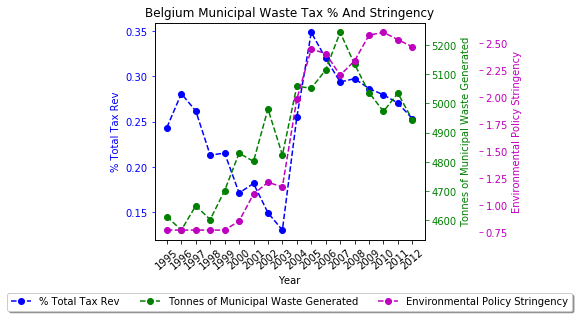

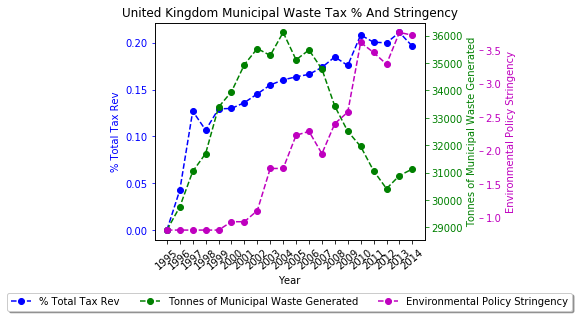

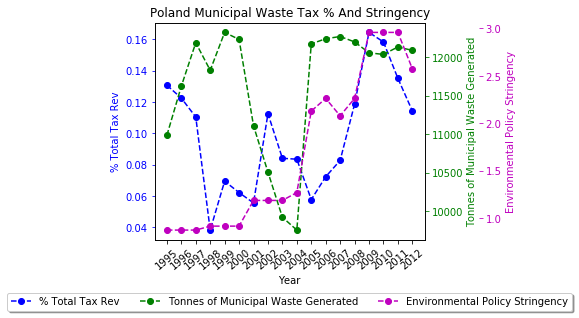

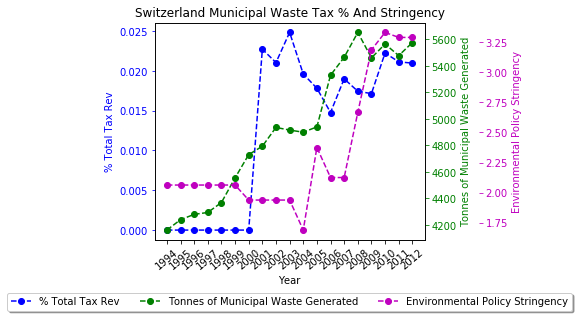

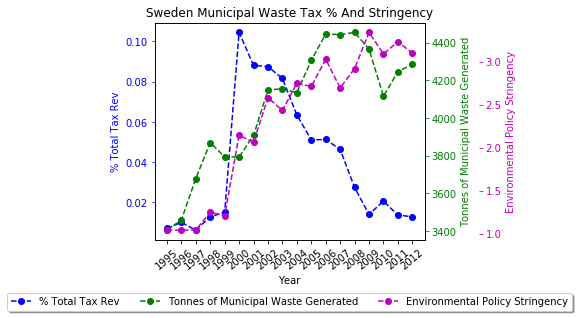

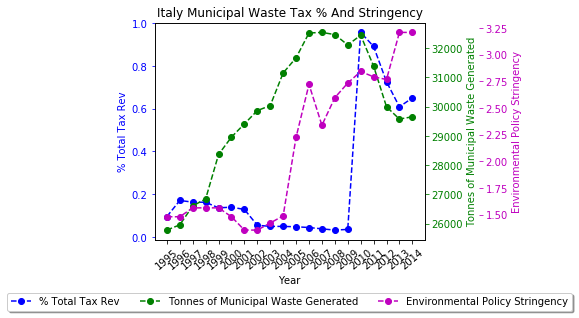

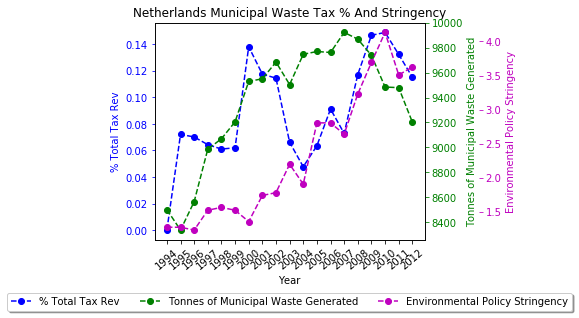

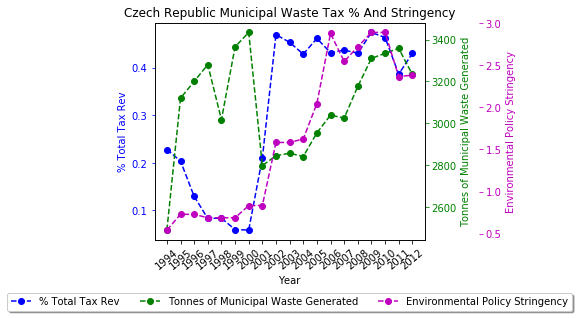

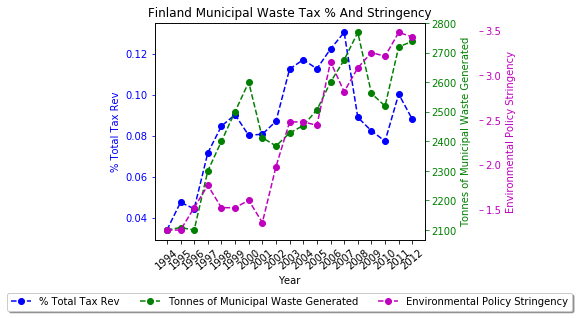

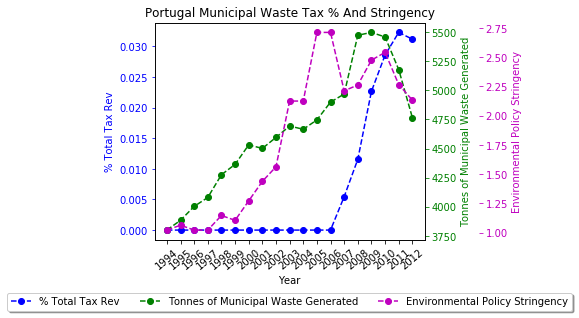

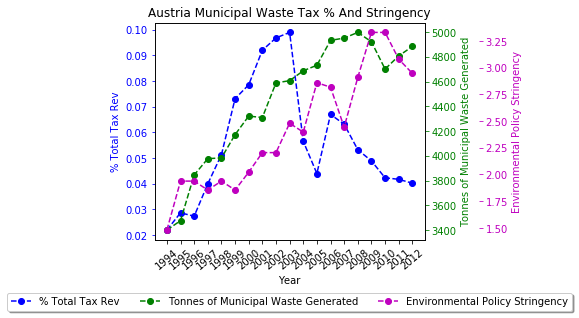

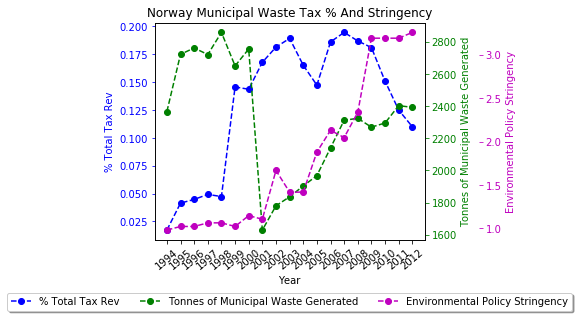

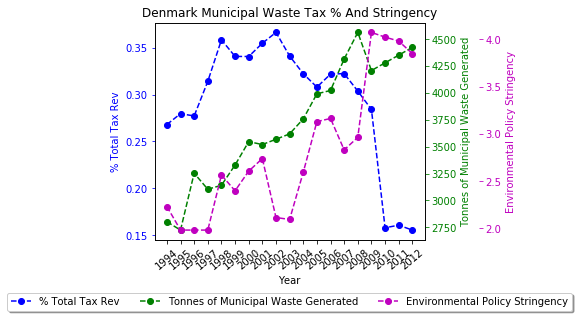

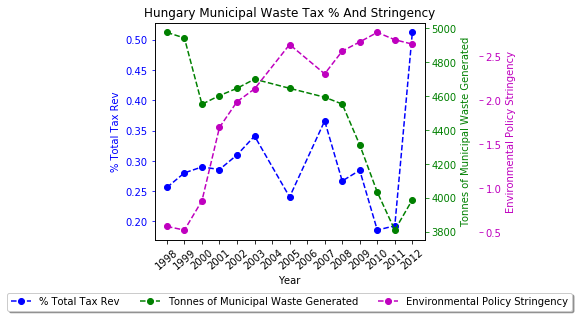

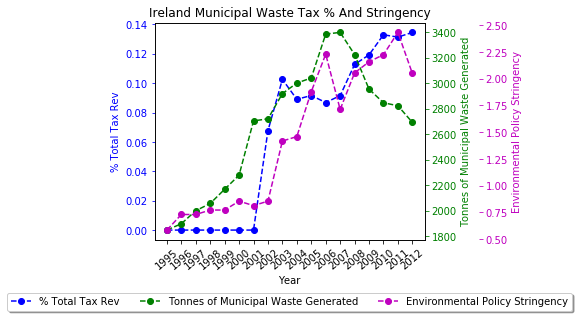

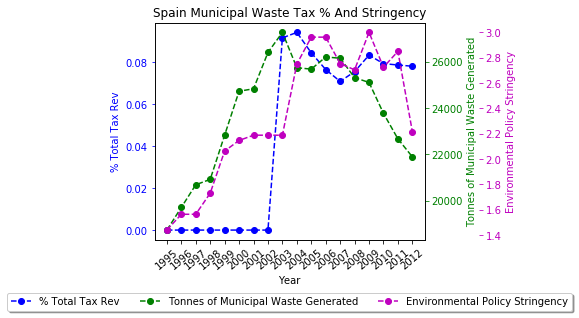

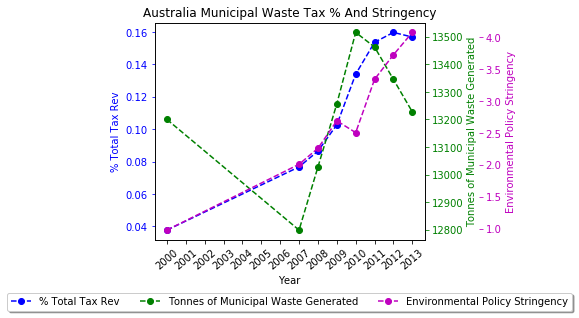

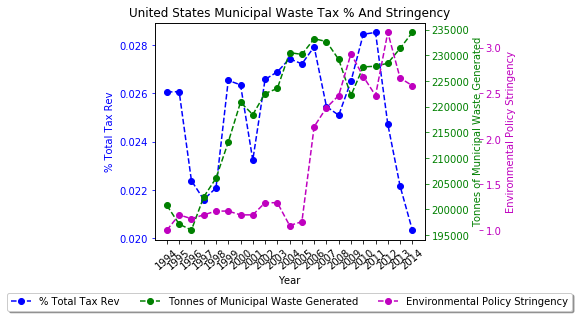

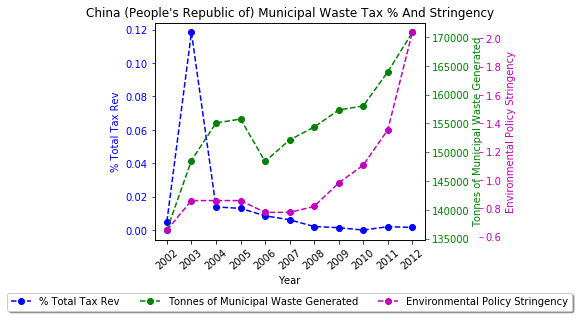

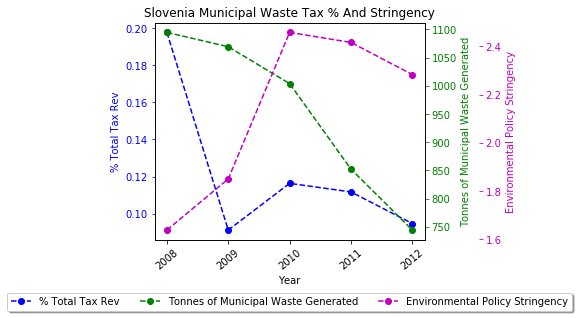

In [13]:
plot_tax_string_pollutant(country_list, year_list, tax_list, pollutant_list, stringency_list, legend_list, \
                              title, x_label)

In [14]:
tax_co2_stringency_df = stringency_df.loc[stringency_df['Variable'] == 'Tax CO2', :].reset_index()
tax_co2_stringency_df = tax_co2_stringency_df.rename(columns={'Value': 'CO2 Tax Stringency'})
tax_co2_stringency_df = tax_co2_stringency_df[['Country', 'Year', 'CO2 Tax Stringency']]
tax_co2_stringency_df.head()

Country  Year  CO2 Tax Stringency
0  Poland  1990                 1.0
1  Poland  1991                 1.0
2  Poland  1992                 1.0
3  Poland  1993                 1.0
4  Poland  1994                 1.0

In [15]:
CO2_df = CO2_df.rename(columns={'Value' : 'Tonnes of CO2 equivalent'})
CO2_df = CO2_df[['Country', 'Year', 'Variable', 'Tonnes of CO2 equivalent']]
CO2_df.head()

Country  Year                           Variable  \
0  Australia  1990  Total  emissions excluding LULUCF   
1  Australia  1991  Total  emissions excluding LULUCF   
2  Australia  1992  Total  emissions excluding LULUCF   
3  Australia  1993  Total  emissions excluding LULUCF   
4  Australia  1994  Total  emissions excluding LULUCF   

   Tonnes of CO2 equivalent  
0                278352.790  
1                279807.363  
2                284840.060  
3                289230.533  
4                293928.812

In [16]:
total_tax_perc_df = tax_perc_df.loc[tax_perc_df['Domain'] == 'Total', :].reset_index()
total_tax_perc_df = total_tax_perc_df[['Country', 'Year', '% Total Tax Rev']]
total_tax_perc_df.head()

Country  Year  % Total Tax Rev
0  Australia  1994         8.437897
1  Australia  1995         9.225419
2  Australia  1996         8.777785
3  Australia  1997         9.778031
4  Australia  1998         9.688228

In [17]:
merged_co2_df = get_unique_countries_merge_dfs(tax_co2_stringency_df, total_tax_perc_df, CO2_df)
print(len(merged_co2_df))
merged_co2_df.head()

Countries in common among these three datasets:
['Australia', 'Austria', 'Belgium', 'Brazil', 'Canada', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'India', 'Ireland', 'Italy', 'Japan', 'Korea', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Slovak Republic', 'Slovenia', 'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'United Kingdom', 'United States']
538


Country  Year  CO2 Tax Stringency  % Total Tax Rev  \
0  Poland  1994                 1.0         4.085836   
1  Poland  1995                 1.0         4.421431   
2  Poland  1996                 1.0         4.768952   
3  Poland  1997                 1.0         4.768043   
4  Poland  1998                 1.0         4.863722   

                            Variable  Tonnes of CO2 equivalent  
0  Total  emissions excluding LULUCF                359822.351  
1  Total  emissions excluding LULUCF                361559.669  
2  Total  emissions excluding LULUCF                375337.125  
3  Total  emissions excluding LULUCF                366599.296  
4  Total  emissions excluding LULUCF                337358.468

In [18]:
country_list, year_list, tax_list, pollutant_list, stringency_list = \
get_lists_for_plotting(merged_co2_df, 'Tonnes of CO2 equivalent', '% Total Tax Rev', \
                       'CO2 Tax Stringency')

In [19]:
legend_list = ['% Total Tax Rev', 'Tonnes of CO2 equivalent', 'CO2 Tax Stringency']
title = 'Total Env Tax % And CO2 Tax Stringency'
x_label = 'Year'

/anaconda3/envs/PythonData/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


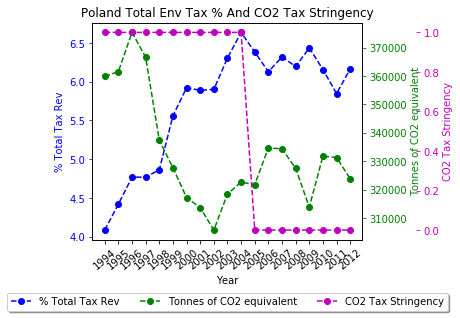

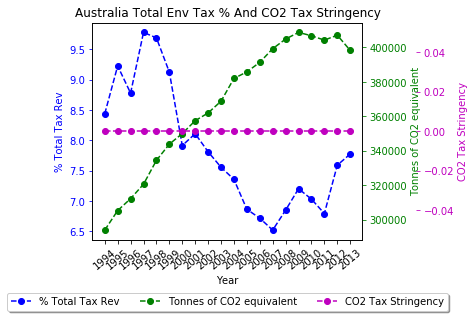

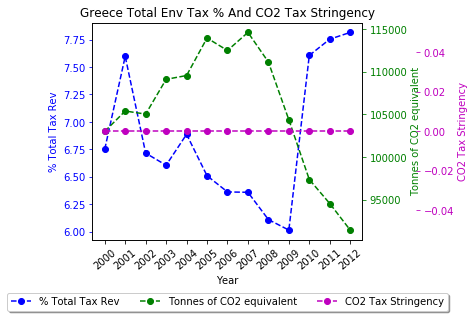

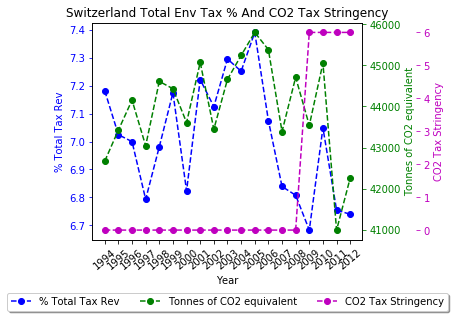

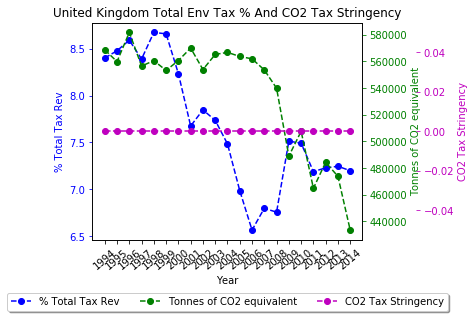

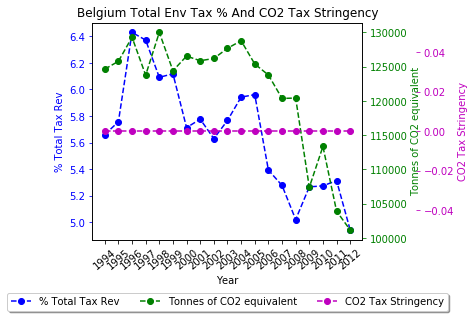

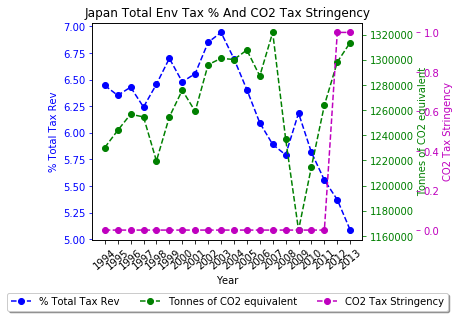

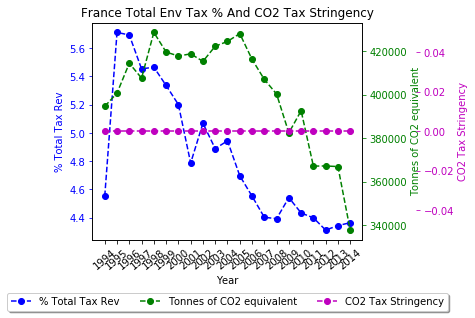

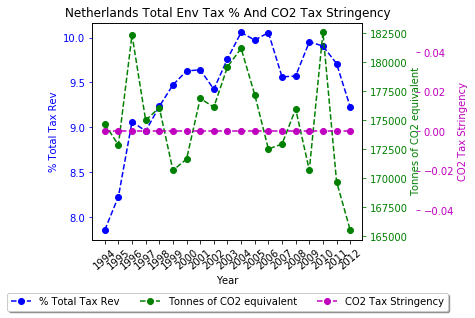

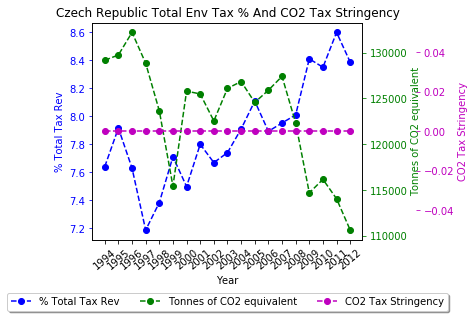

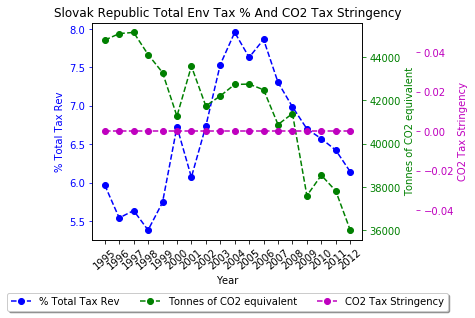

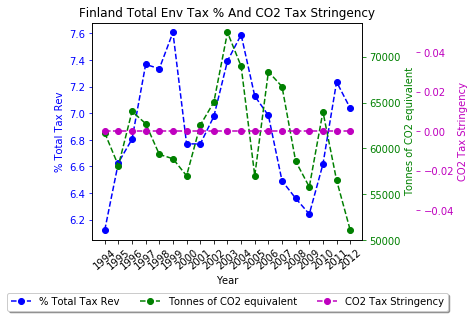

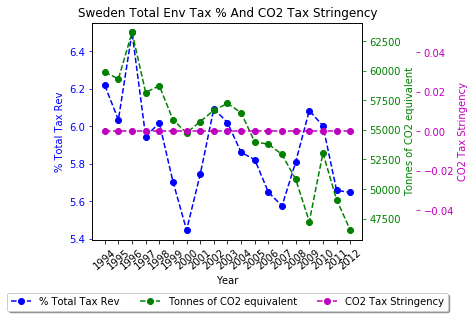

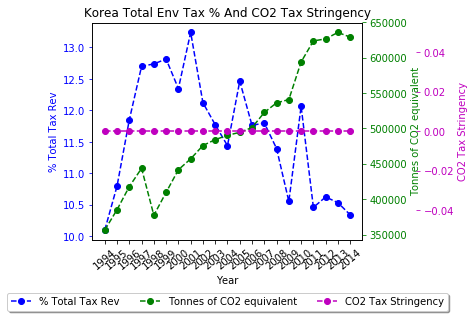

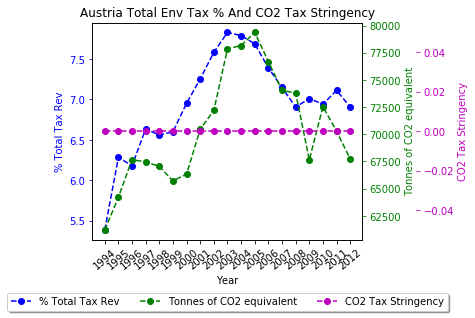

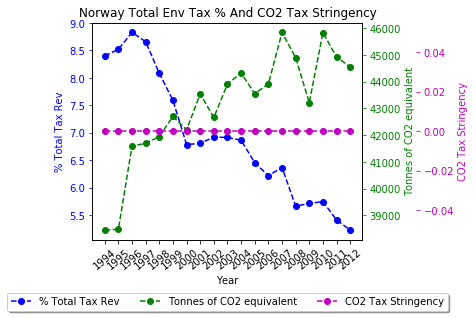

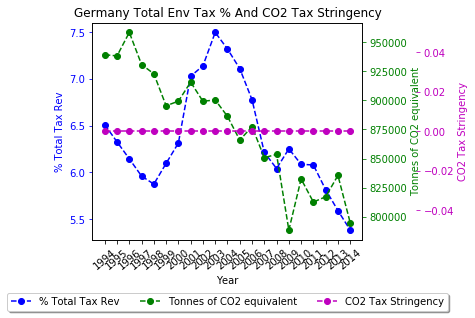

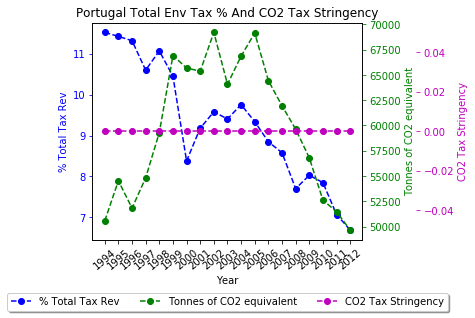

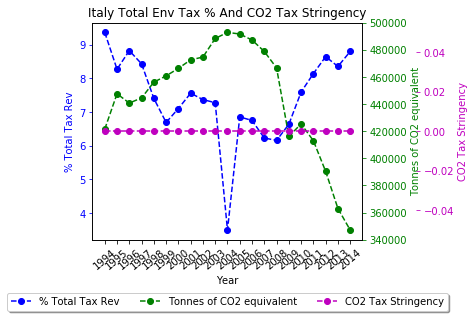

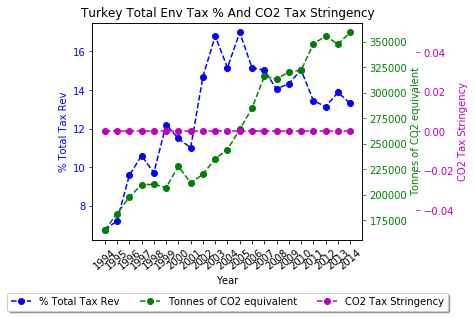

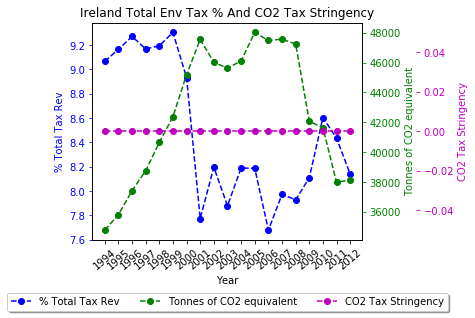

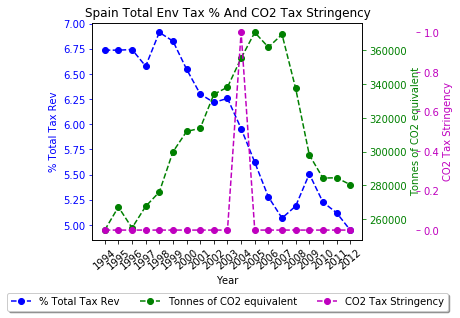

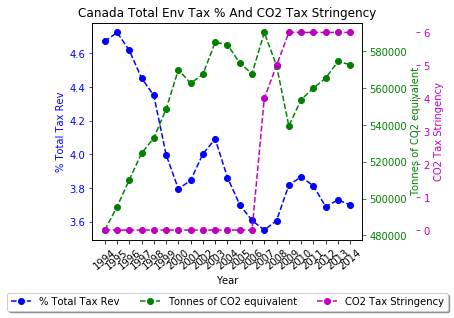

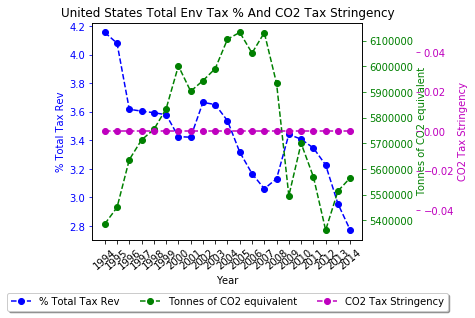

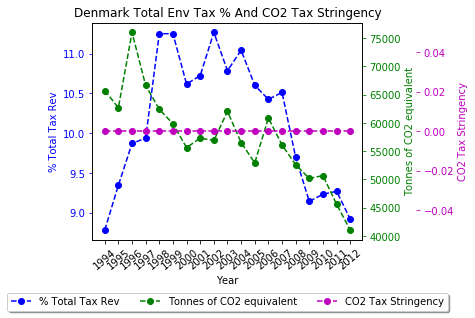

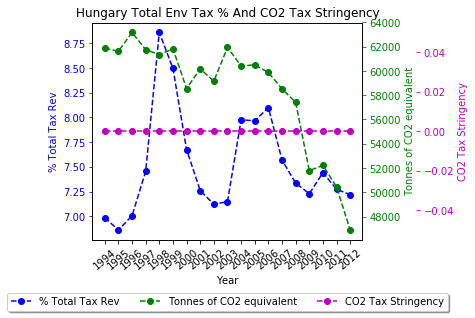

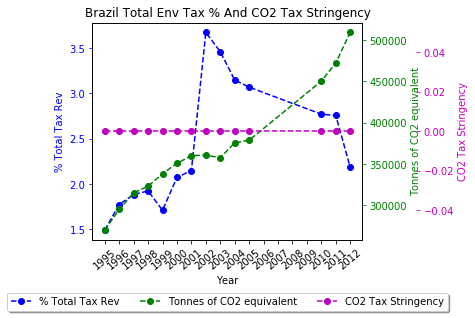

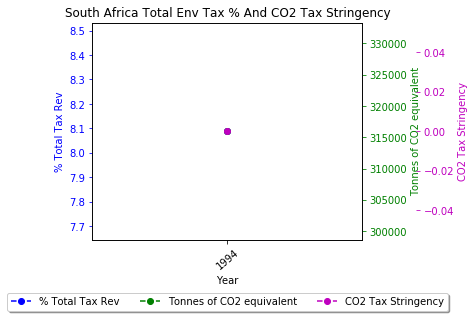

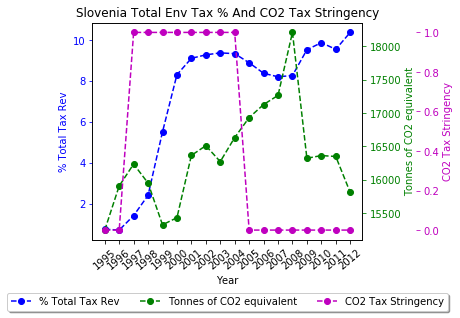

In [20]:
plot_tax_string_pollutant(country_list, year_list, tax_list, pollutant_list, stringency_list, legend_list, \
                              title, x_label)

In [21]:
print(len(merged_co2_df))
merged_co2_df = remove_zero_values_df(merged_co2_df, 'CO2 Tax Stringency')
print(len(merged_co2_df))

538
116


In [22]:
country_list, year_list, tax_list, pollutant_list, stringency_list = \
get_lists_for_plotting(merged_co2_df, 'Tonnes of CO2 equivalent', '% Total Tax Rev', \
                       'CO2 Tax Stringency')


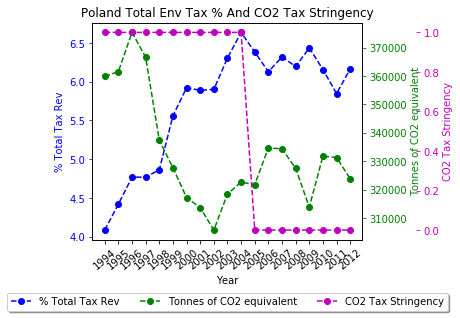

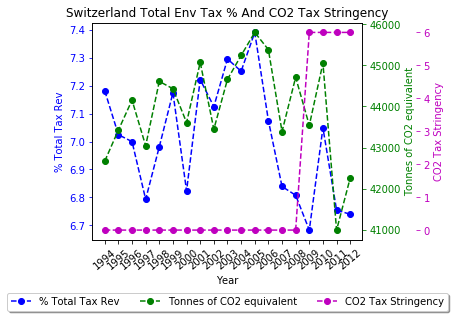

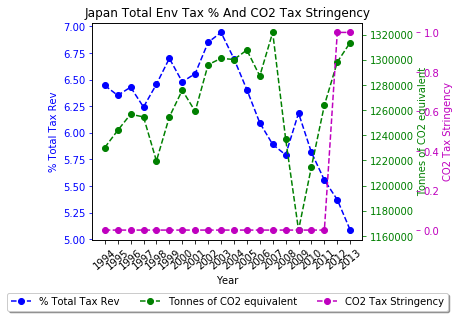

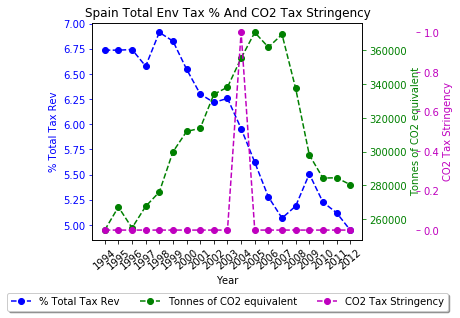

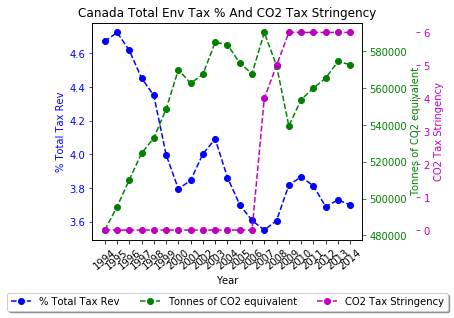

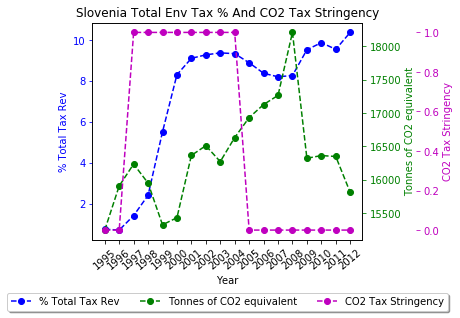

In [23]:
plot_tax_string_pollutant(country_list, year_list, tax_list, pollutant_list, stringency_list, legend_list, \
                              title, x_label)

In [24]:
merged_co2_df = get_unique_countries_merge_dfs(EPS_stringency_df, total_tax_perc_df, CO2_df)
print(len(merged_co2_df))
merged_co2_df.head()

Countries in common among these three datasets:
['Australia', 'Austria', 'Belgium', 'Brazil', 'Canada', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'India', 'Ireland', 'Italy', 'Japan', 'Korea', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Slovak Republic', 'Slovenia', 'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'United Kingdom', 'United States']
525


Country  Year  Environmental Policy Stringency  % Total Tax Rev  \
0  Belgium  1994                         0.770833         5.660082   
1  Belgium  1995                         0.770833         5.756420   
2  Belgium  1996                         0.770833         6.428968   
3  Belgium  1997                         0.770833         6.371275   
4  Belgium  1998                         0.770833         6.090822   

                            Variable  Tonnes of CO2 equivalent  
0  Total  emissions excluding LULUCF                124623.830  
1  Total  emissions excluding LULUCF                125762.543  
2  Total  emissions excluding LULUCF                129271.934  
3  Total  emissions excluding LULUCF                123745.603  
4  Total  emissions excluding LULUCF                129974.882

In [25]:
country_list, year_list, tax_list, pollutant_list, stringency_list = \
get_lists_for_plotting(merged_co2_df, 'Tonnes of CO2 equivalent', '% Total Tax Rev', \
                       'Environmental Policy Stringency')

In [26]:
legend_list = ['% Total Tax Rev', 'Tonnes of CO2 equivalent', 'Environmental Policy Stringency']
title = 'Total CO2 Emissions Excluding LULUCF'
x_label = 'Year'

/anaconda3/envs/PythonData/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


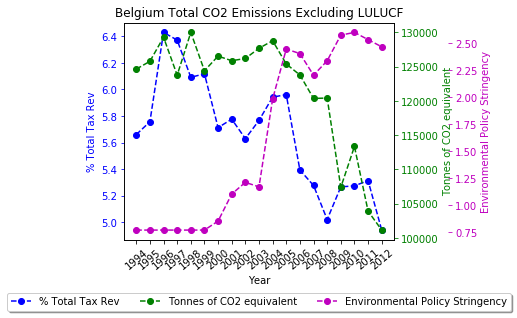

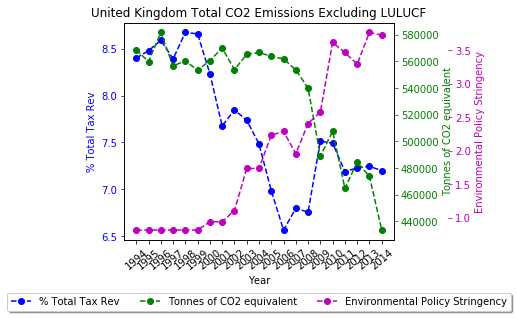

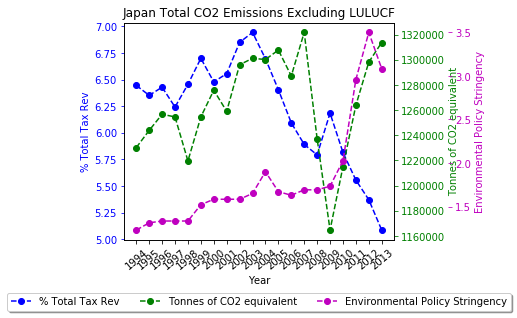

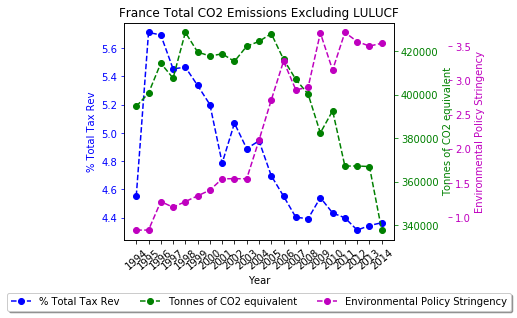

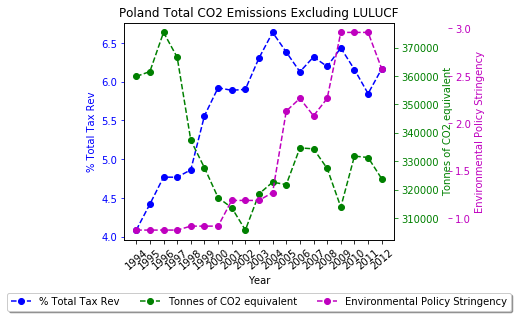

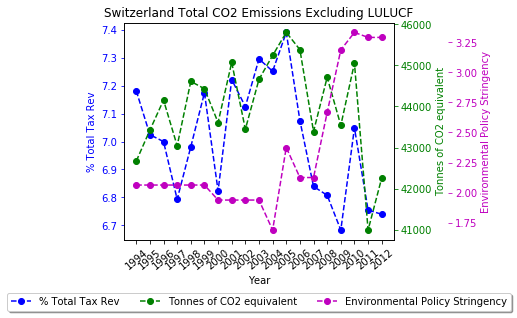

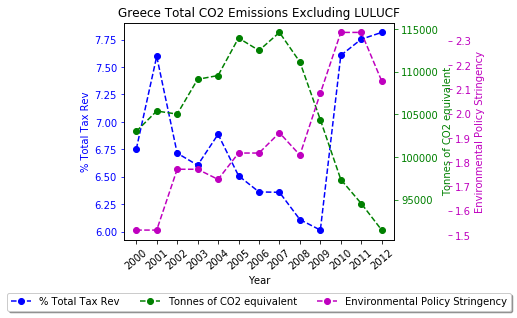

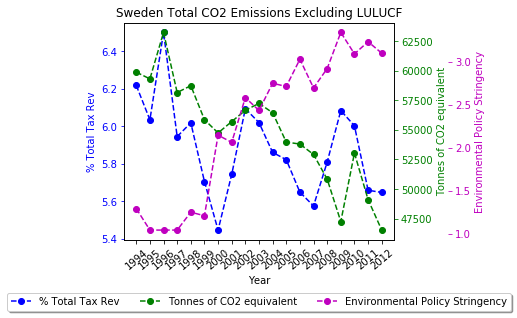

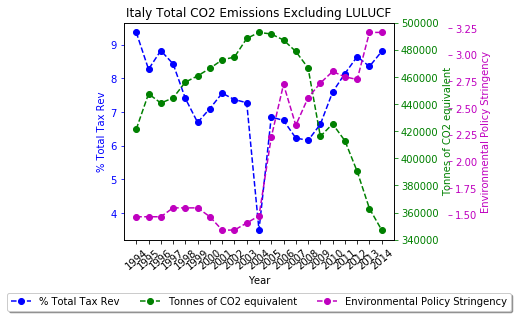

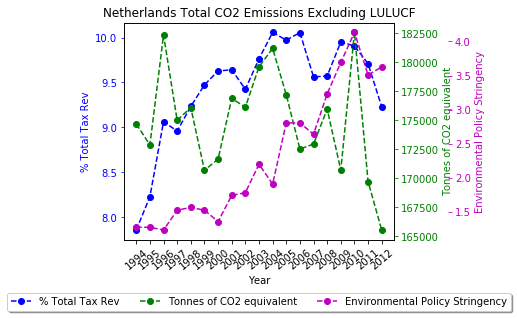

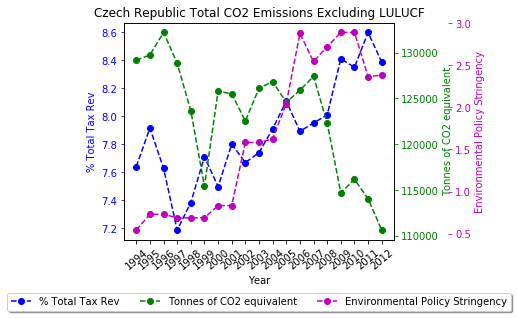

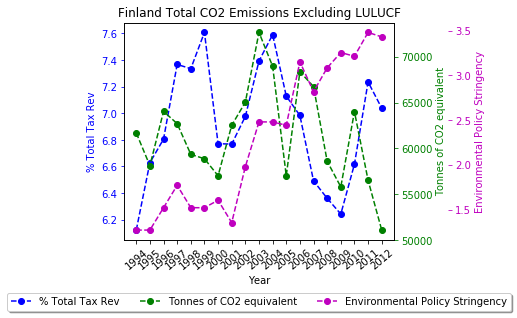

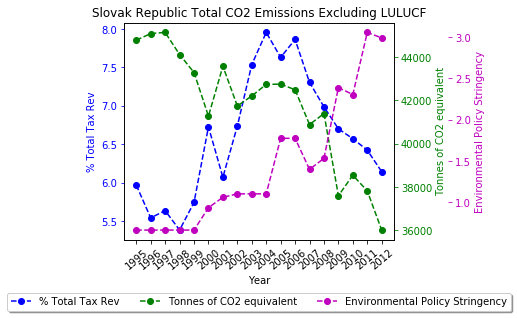

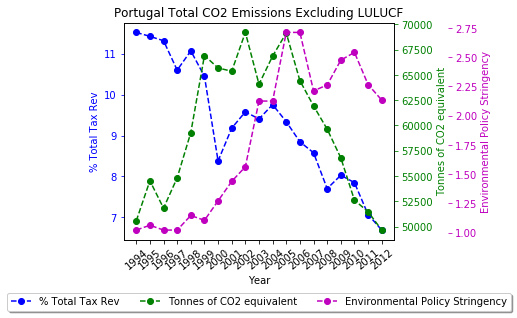

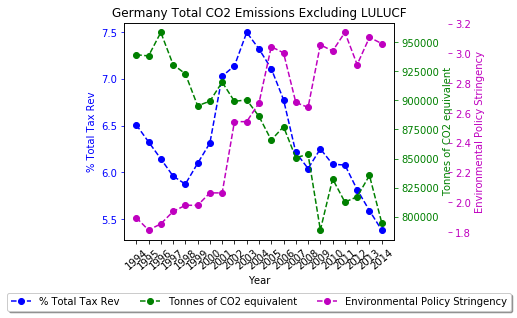

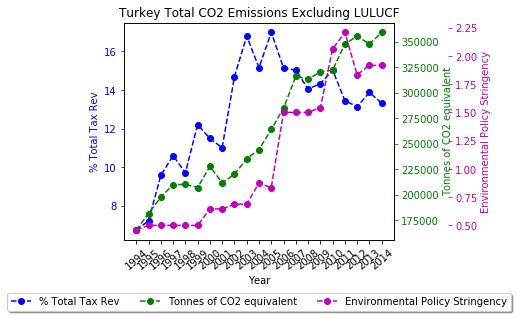

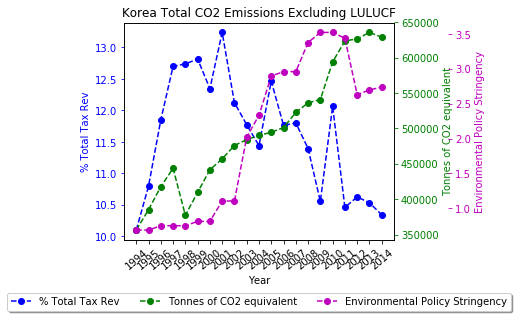

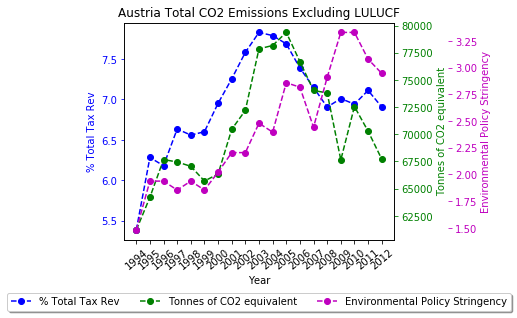

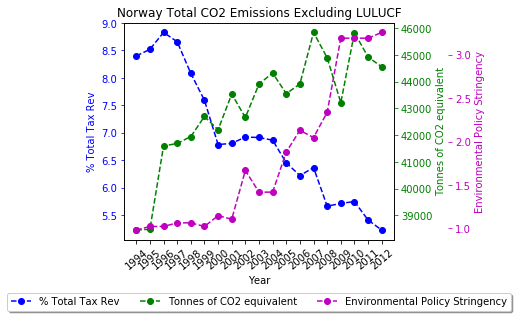

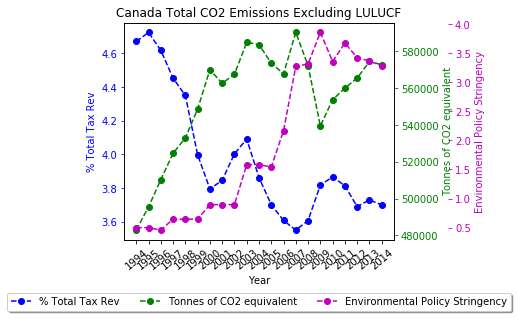

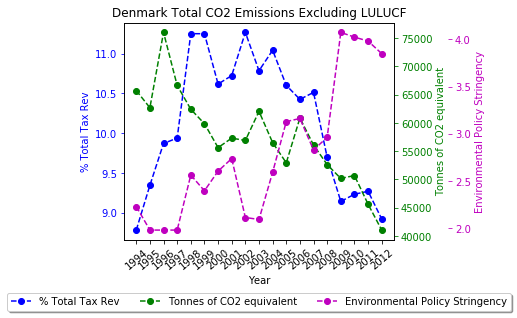

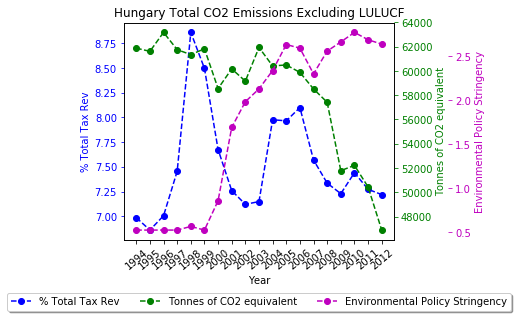

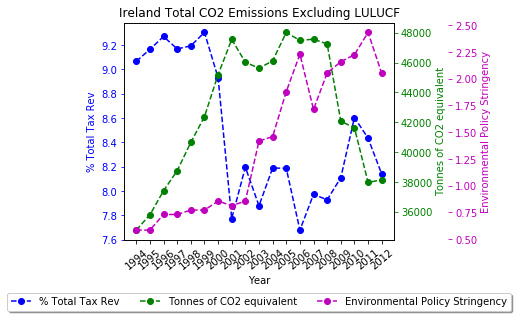

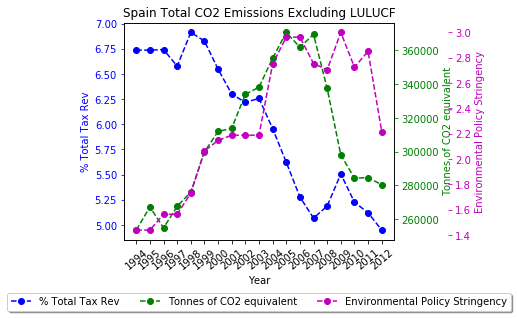

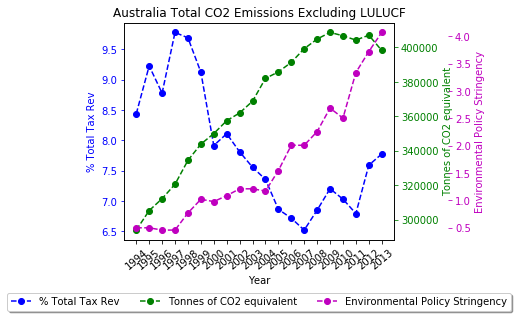

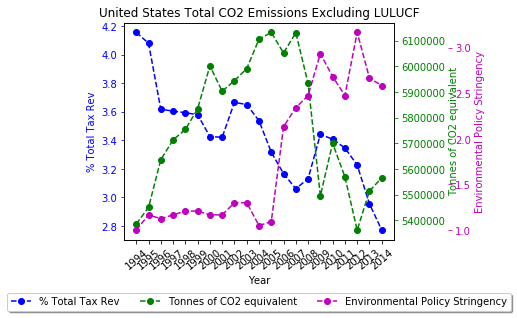

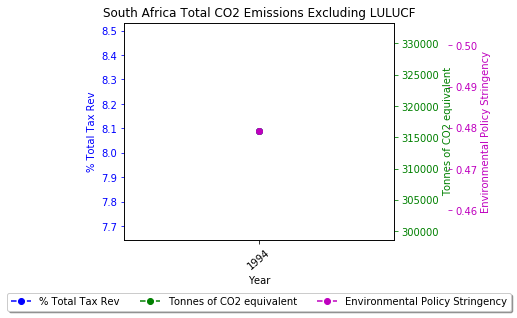

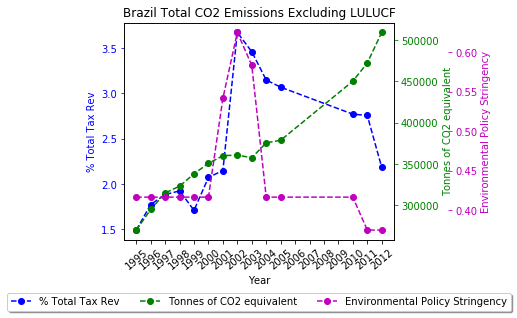

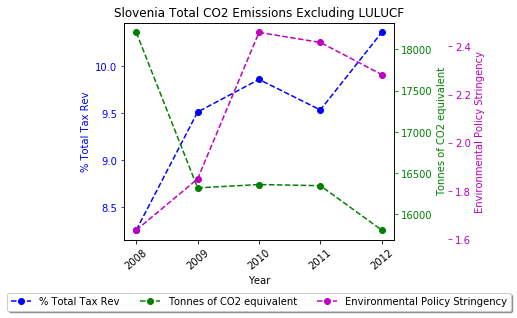

In [27]:
plot_tax_string_pollutant(country_list, year_list, tax_list, pollutant_list, stringency_list, legend_list, \
                              title, x_label)

In [28]:
merged_RD_df = get_unique_countries_merge_dfs(EPS_stringency_df, total_tax_perc_df, RD_df)
print(len(merged_RD_df))
merged_RD_df.head()

Countries in common among these three datasets:
['Australia', 'Austria', 'Belgium', 'Canada', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Japan', 'Korea', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Slovak Republic', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'United Kingdom', 'United States']
350


Country  Year  Environmental Policy Stringency  % Total Tax Rev  \
0  Belgium  1995                         0.770833         5.756420   
1  Belgium  2000                         0.854167         5.712360   
2  Belgium  2001                         1.104167         5.776090   
3  Belgium  2002                         1.212500         5.629534   
4  Belgium  2003                         1.170833         5.766455   

   Percent Total Gov R&D Budget For Env  
0                              1.746768  
1                              3.309411  
2                              2.643736  
3                              2.678060  
4                              2.091430

In [29]:
country_list, year_list, tax_list, pollutant_list, stringency_list = \
get_lists_for_plotting(merged_RD_df, 'Percent Total Gov R&D Budget For Env', '% Total Tax Rev', \
                       'Environmental Policy Stringency')

In [30]:
legend_list = ['% Total Tax Rev', 'Percent Total Gov R&D Budget For Env', 'Environmental Policy Stringency']
title = 'Percent Total Gov R&D Budget For Env '
x_label = 'Year'

/anaconda3/envs/PythonData/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


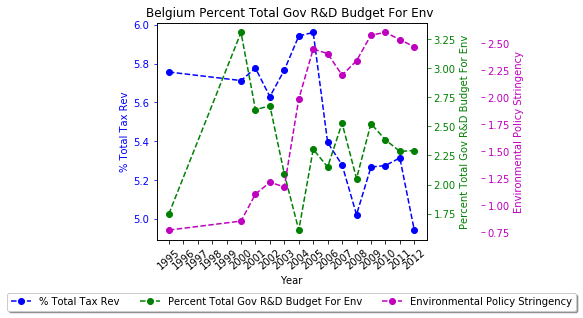

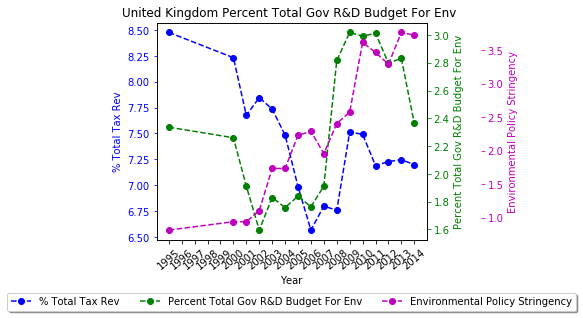

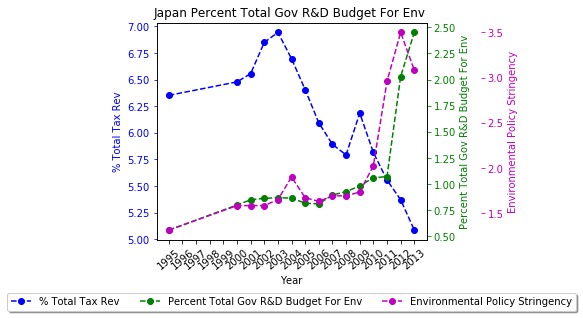

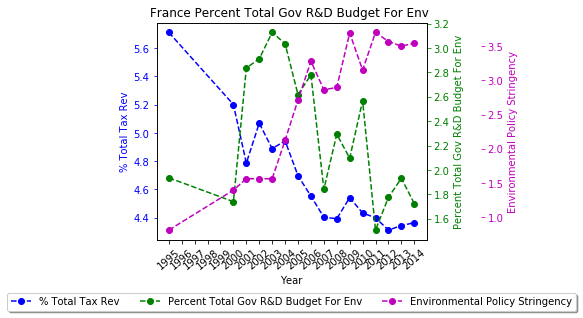

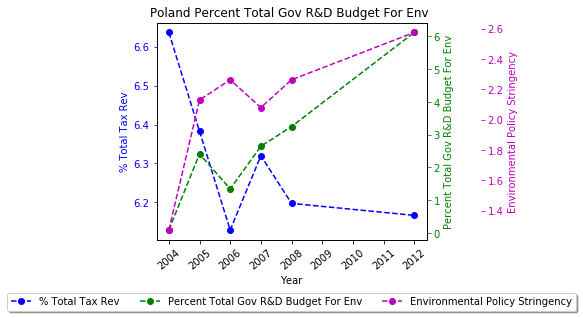

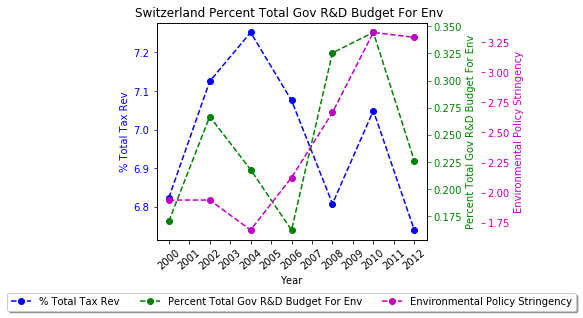

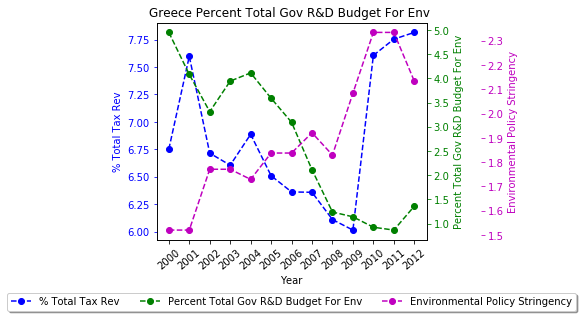

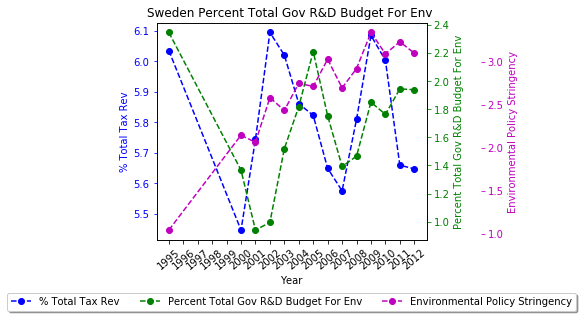

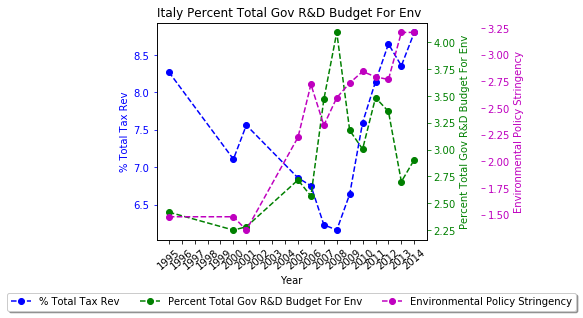

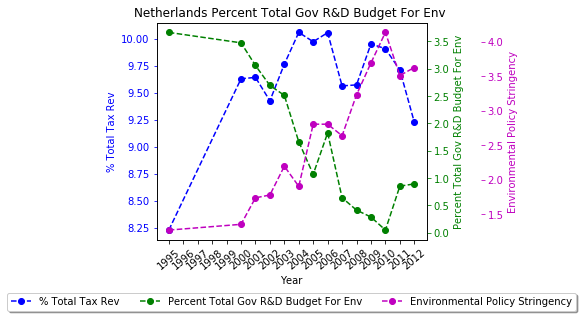

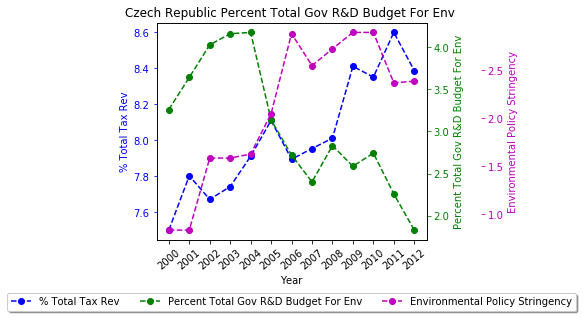

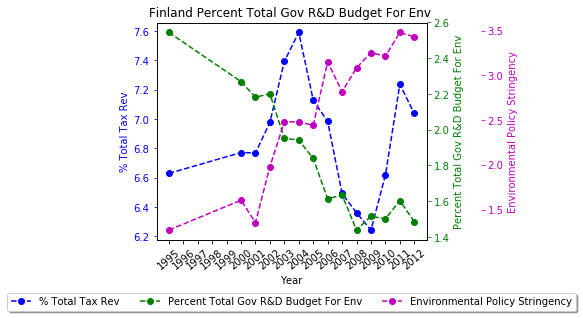

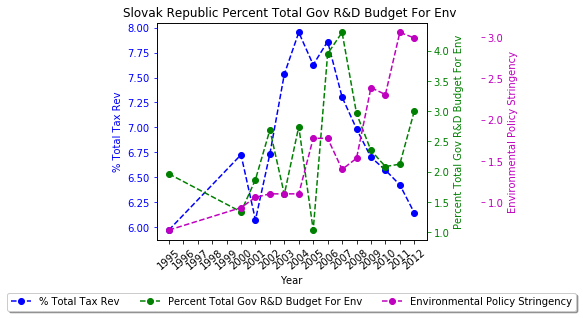

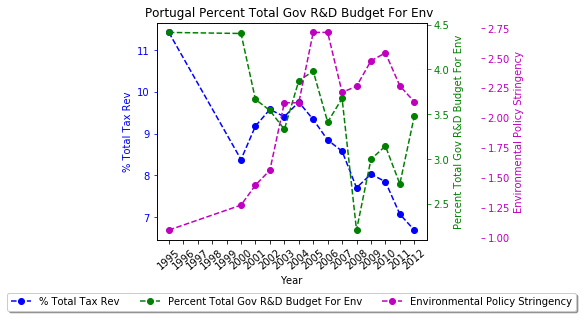

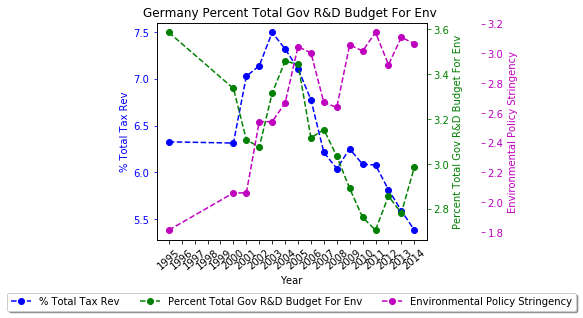

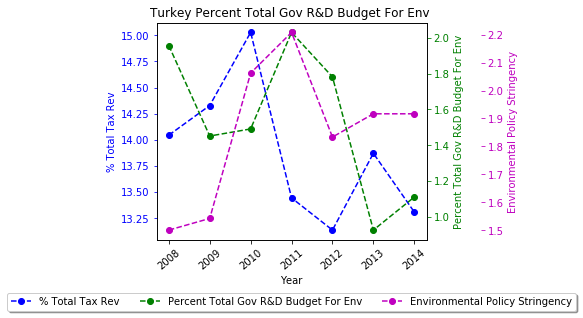

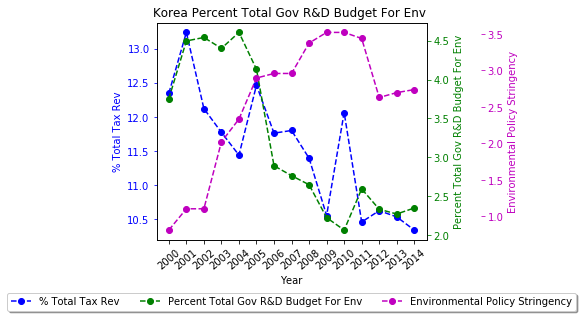

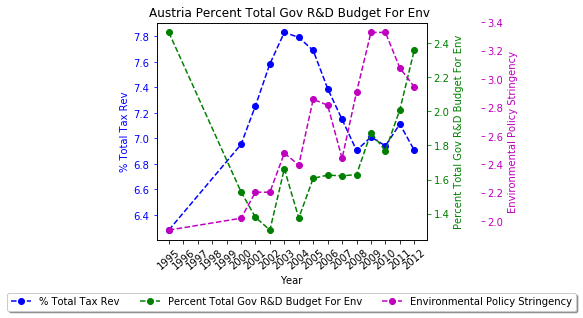

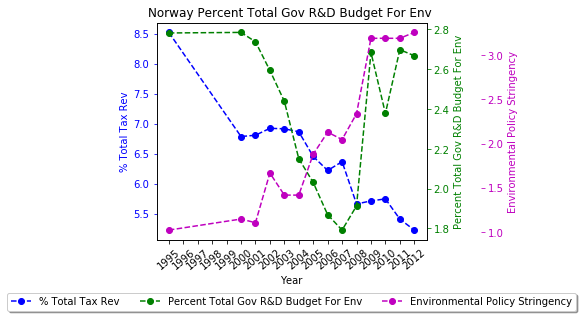

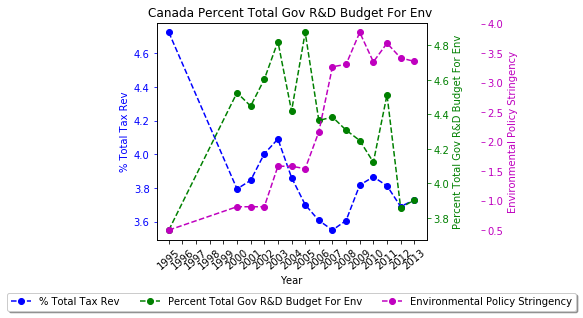

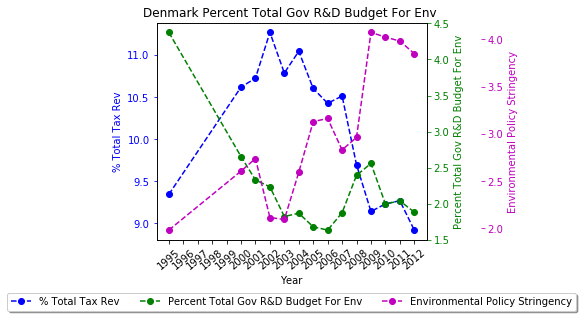

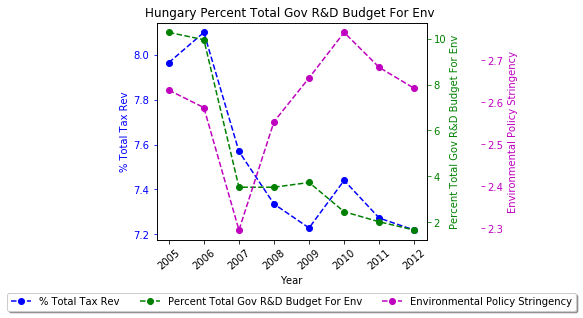

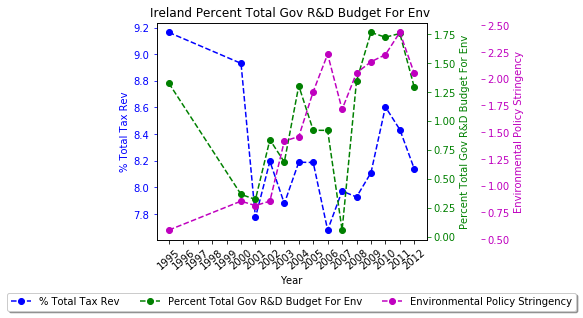

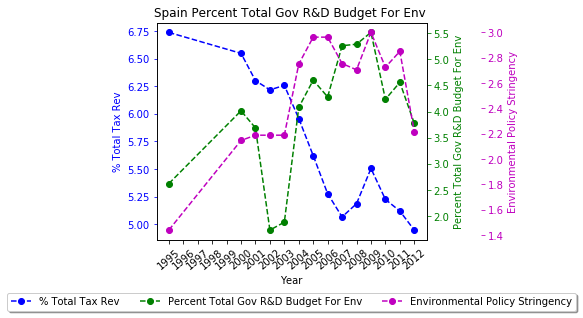

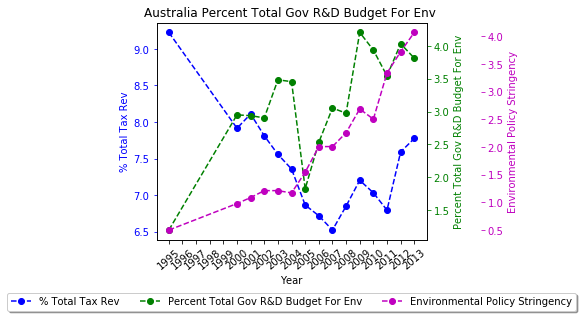

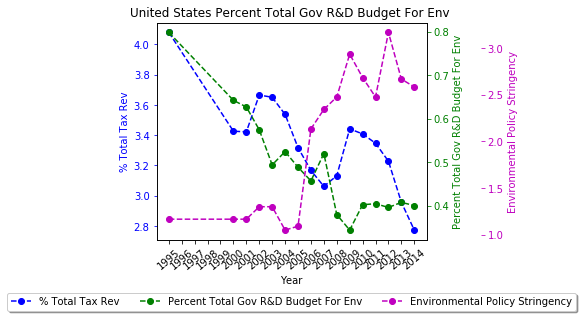

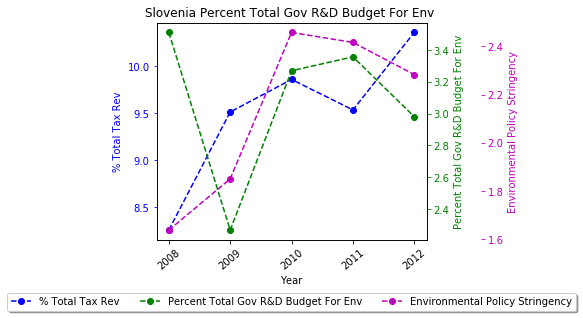

In [31]:
plot_tax_string_pollutant(country_list, year_list, tax_list, pollutant_list, stringency_list, legend_list, \
                              title, x_label)

In [32]:
GHG_df = GHG_df.rename(columns={'Value': 'Tonnes of CO2 equivalent'})
GHG_df = GHG_df[['Country', 'Year', 'Variable', 'Tonnes of CO2 equivalent']]
GHG_df.head()

Country  Year                           Variable  \
0  Australia  1990  Total  emissions excluding LULUCF   
1  Australia  1991  Total  emissions excluding LULUCF   
2  Australia  1992  Total  emissions excluding LULUCF   
3  Australia  1993  Total  emissions excluding LULUCF   
4  Australia  1994  Total  emissions excluding LULUCF   

   Tonnes of CO2 equivalent  
0                419843.155  
1                420927.191  
2                425820.883  
3                426128.333  
4                426074.577

In [33]:
merged_GHG_df = get_unique_countries_merge_dfs(EPS_stringency_df, total_tax_perc_df, GHG_df)
print(len(merged_GHG_df))
merged_GHG_df.head()

Countries in common among these three datasets:
['Australia', 'Austria', 'Belgium', 'Brazil', 'Canada', "China (People's Republic of)", 'Czech Republic', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'India', 'Ireland', 'Italy', 'Japan', 'Korea', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Slovak Republic', 'Slovenia', 'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'United Kingdom', 'United States']
530


Country  Year  Environmental Policy Stringency  % Total Tax Rev  \
0  Belgium  1994                         0.770833         5.660082   
1  Belgium  1995                         0.770833         5.756420   
2  Belgium  1996                         0.770833         6.428968   
3  Belgium  1997                         0.770833         6.371275   
4  Belgium  1998                         0.770833         6.090822   

                            Variable  Tonnes of CO2 equivalent  
0  Total  emissions excluding LULUCF                152160.400  
1  Total  emissions excluding LULUCF                154348.237  
2  Total  emissions excluding LULUCF                158013.764  
3  Total  emissions excluding LULUCF                149500.389  
4  Total  emissions excluding LULUCF                154661.073

In [34]:
country_list, year_list, tax_list, pollutant_list, stringency_list = \
get_lists_for_plotting(merged_GHG_df, 'Tonnes of CO2 equivalent', '% Total Tax Rev', \
                       'Environmental Policy Stringency')

In [35]:
legend_list = ['% Total Tax Rev', 'Tonnes of CO2 equivalent', 'Environmental Policy Stringency']
title = 'Total GHG Emissions Excluding LULUCF'
x_label = 'Year'

/anaconda3/envs/PythonData/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


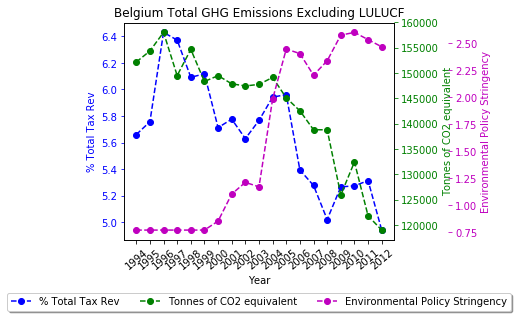

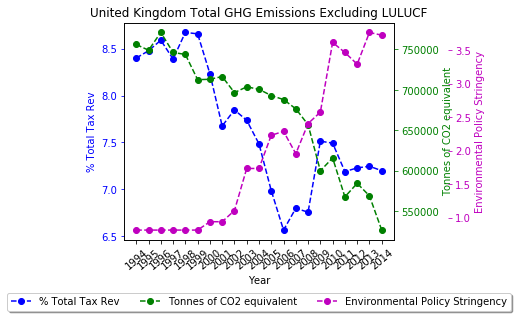

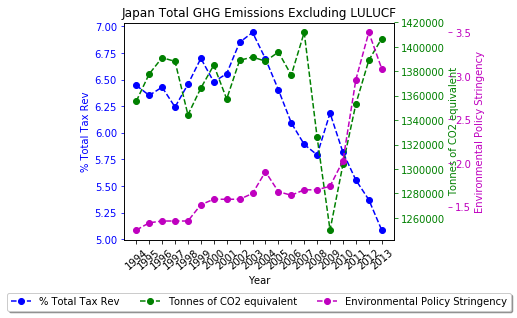

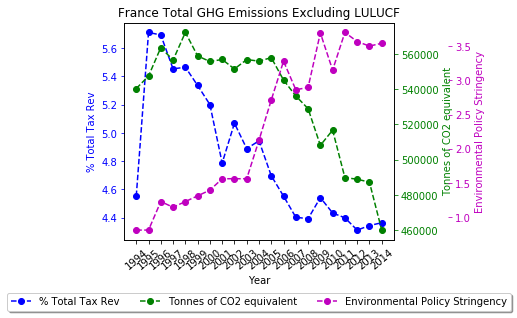

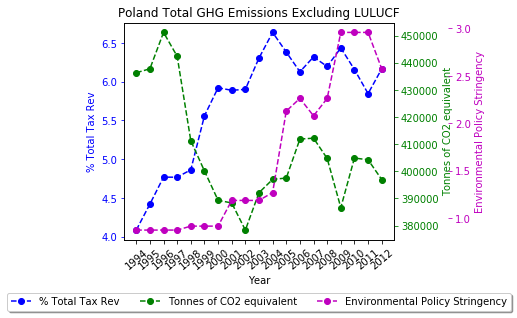

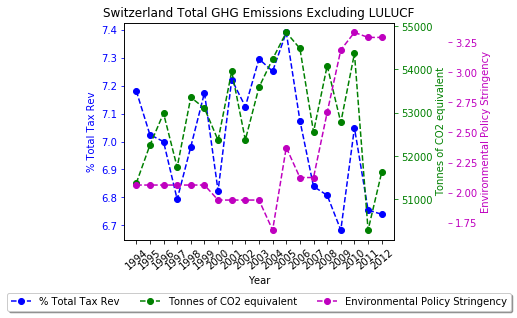

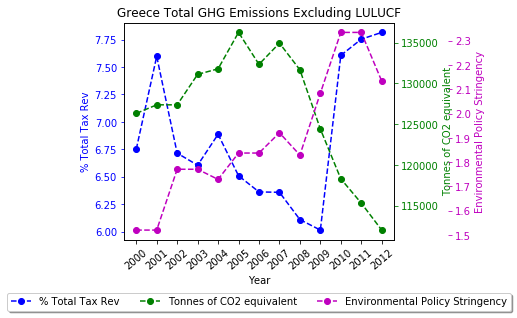

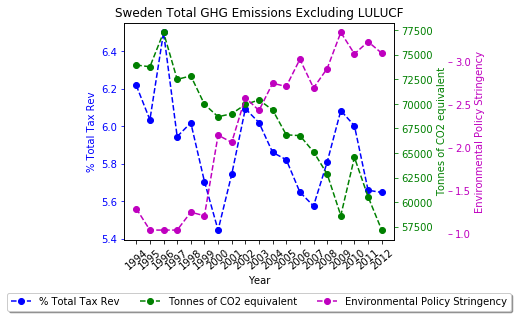

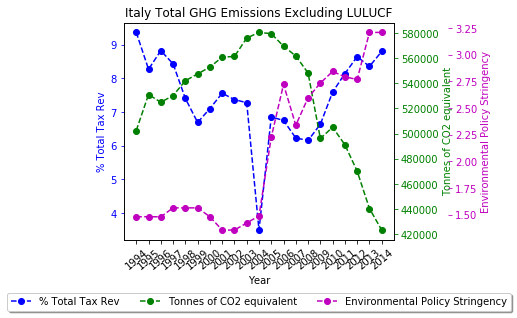

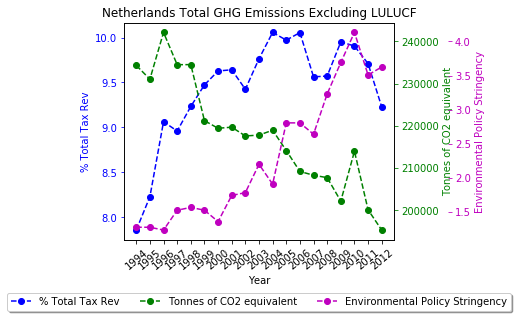

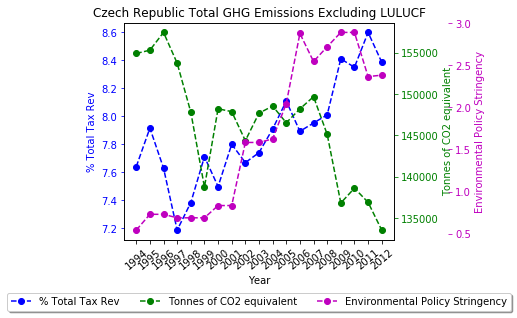

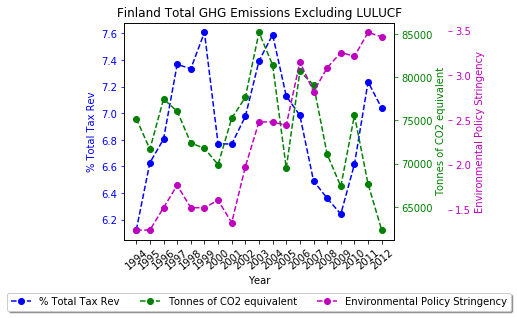

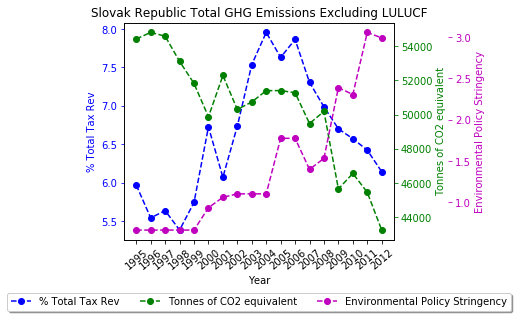

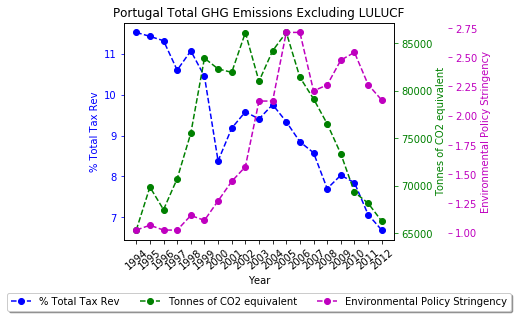

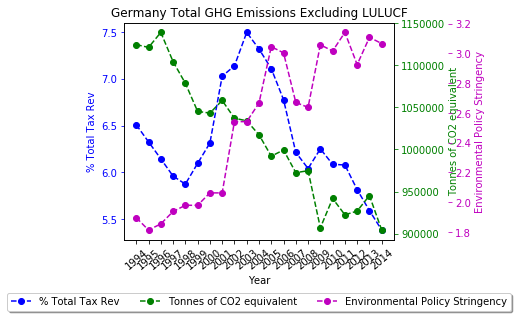

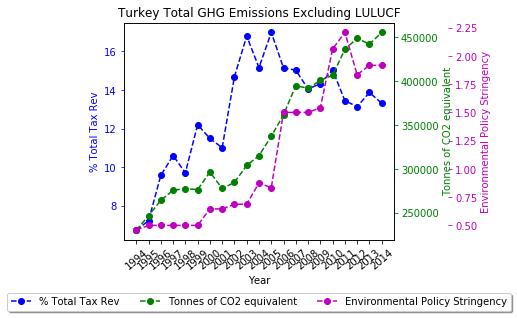

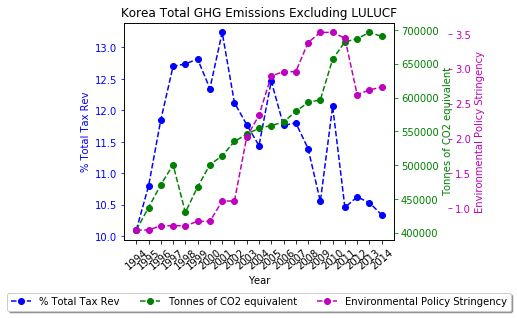

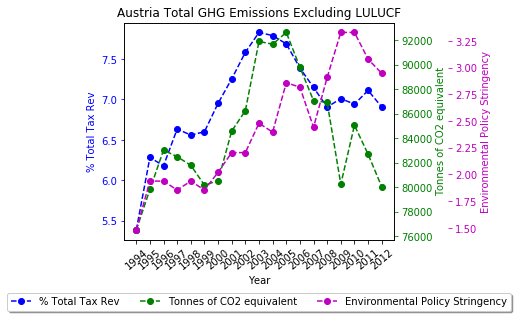

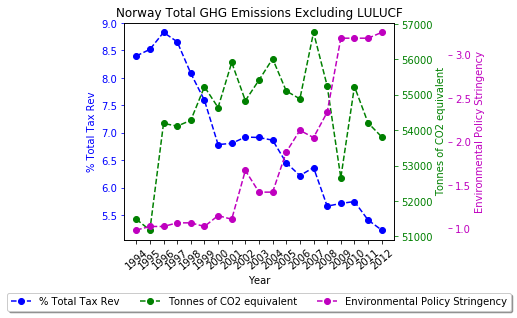

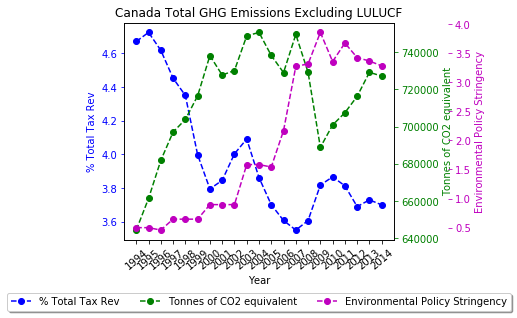

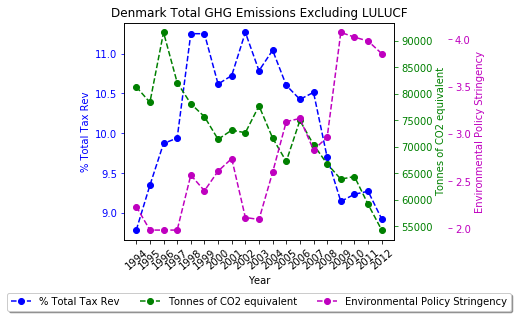

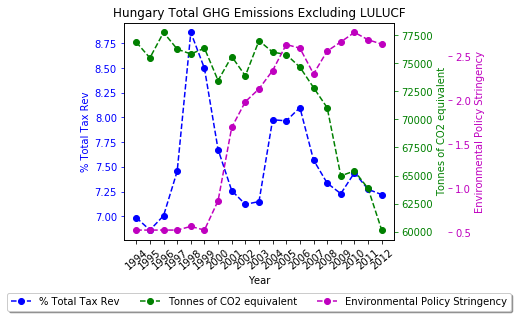

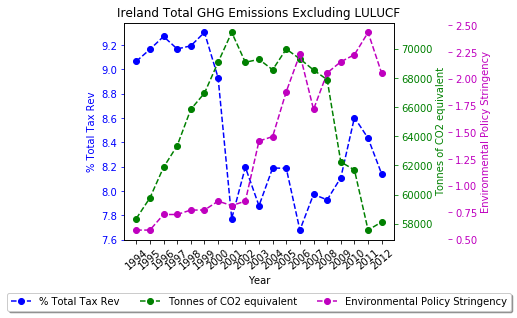

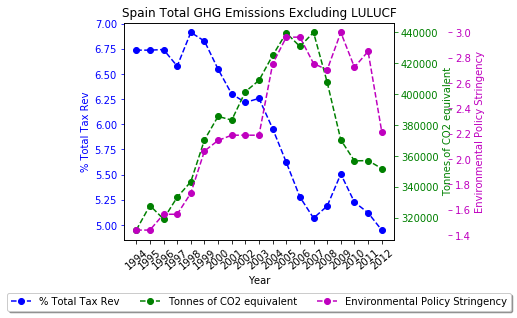

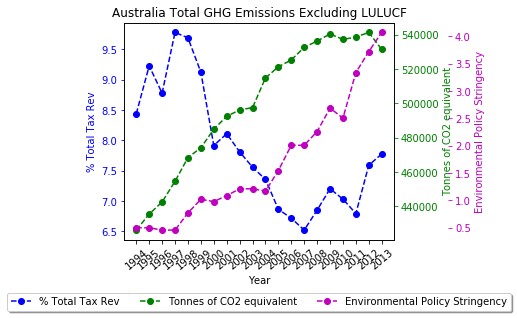

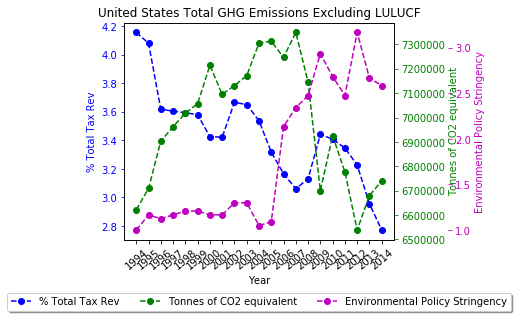

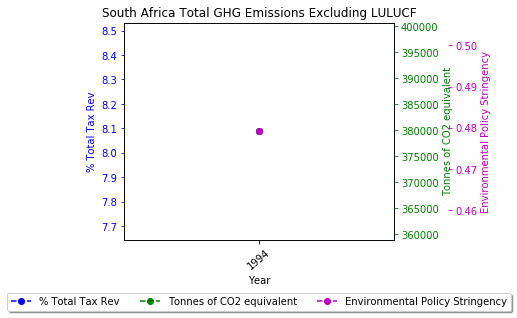

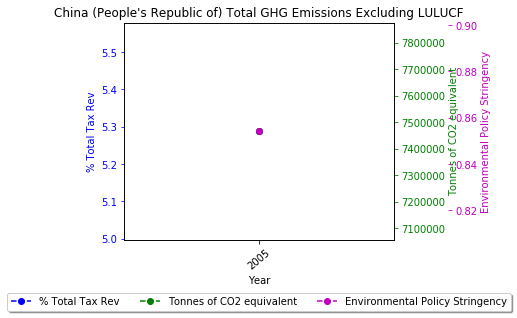

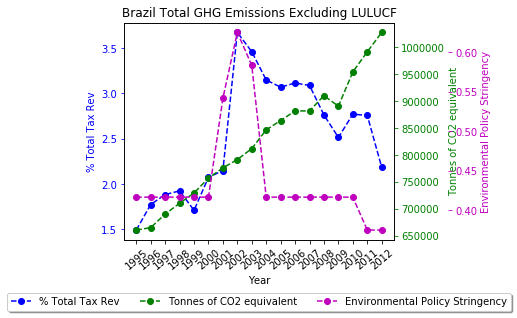

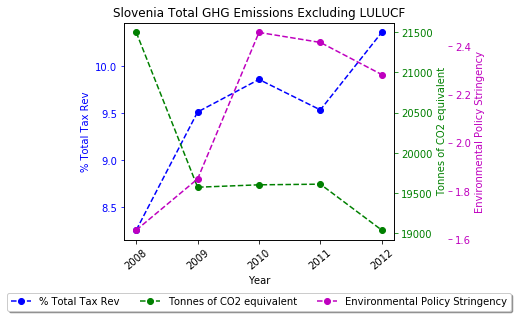

In [36]:
plot_tax_string_pollutant(country_list, year_list, tax_list, pollutant_list, stringency_list, legend_list, \
                              title, x_label)

In [54]:
GDP_df.head()
GDP_countries = list(GDP_df['Country'].unique())
GDP_country_list = []
GDP_year_list = []
GDP_value_list = []

for x, country in zip(range(len(GDP_countries)), GDP_countries):
    df = GDP_df.loc[GDP_df['Country'] == country, :].reset_index()
    years = list(df['Year'].values)
    GDP_values = list(df['GDP Per Capita USD2010PPP'].values)
    
    GDP_country_list.append(country)
    GDP_year_list.append(years)
    GDP_value_list.append(GDP_values)

In [67]:
GDP_binning_country = []
GDP_binning_year = []
GDP_binning_value = []
country_num = len(GDP_country_list)

for x in range(country_num):
    most_recent_year = GDP_year_list[x][len(GDP_year_list[x]) - 1]
    most_recent_GDP = GDP_value_list[x][len(GDP_value_list[x]) - 1]
    country = GDP_country_list[x]
    
    GDP_binning_country.append(country)
    GDP_binning_year.append(most_recent_year)
    GDP_binning_value.append(most_recent_GDP)
    
GDP_binning_data = {
    'Country' : GDP_binning_country, 
    'Most Recent Reporting Year' : GDP_binning_year,
    'GDP Per Capita USD2010PPP' : GDP_binning_value
}

GDP_binning_df = pd.DataFrame(GDP_binning_data)
GDP_binning_df.head()

Country  Most Recent Reporting Year  GDP Per Capita USD2010PPP
0       Australia                        2017                   46240.15
1         Austria                        2017                   44412.60
2         Belgium                        2017                   41435.94
3          Canada                        2017                   43370.15
4  Czech Republic                        2017                   31767.65

In [76]:
print(f"Max: {max(list(GDP_binning_df['GDP Per Capita USD2010PPP']))}")
print(f"Min: {min(list(GDP_binning_df['GDP Per Capita USD2010PPP']))}")
#plt.bar(GDP_binning_df['Country'], GDP_binning_df['GDP Per Capita USD2010PPP'])

GDP_bins = [0, 9999, 19999, 29999, 49999, 9999999999999]
group_names = ["<10,000", "10,000-19,999", "20,000-29,999", "30,000-49,999", "50,000+"]
GDP_binning_df['GDP bin'] = pd.cut(GDP_binning_df['GDP Per Capita USD2010PPP'], GDP_bins, labels = group_names)

sub_10k_df = GDP_binning_df.loc[GDP_binning_df['GDP bin'] == '<10,000', :].reset_index()
GDP_10k_20k_df = GDP_binning_df.loc[GDP_binning_df['GDP bin'] == '10,000-19,999', :].reset_index()
GDP_20k_30k_df = GDP_binning_df.loc[GDP_binning_df['GDP bin'] == '20,000-29,999', :].reset_index()
GDP_30k_50k_df = GDP_binning_df.loc[GDP_binning_df['GDP bin'] == '30,000-49,999', :].reset_index()
GDP_50k_plus_df = GDP_binning_df.loc[GDP_binning_df['GDP bin'] == '50,000+', :].reset_index()

Max: 115816.0
Min: 895.9688


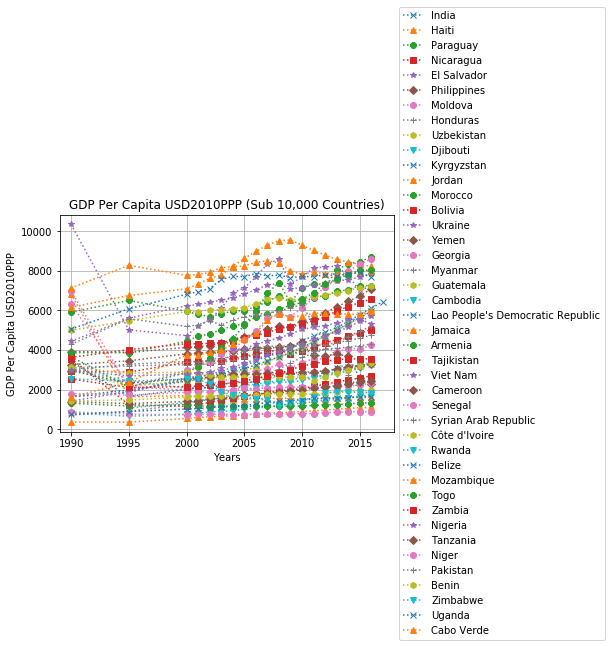

In [81]:
countries = tuple(sub_10k_df['Country'].unique())
markers = ['x', '^', '8', 's', '*', 'D', 'o', '+', 'h', 'v']
counter = 0

for country in countries:
    df = GDP_df.loc[GDP_df['Country'] == country, :].reset_index()
    years = tuple(df['Year'])
    GDP_values = tuple(df['GDP Per Capita USD2010PPP'])
    plt.plot(years, GDP_values, marker=markers[counter], linestyle=':')
    if counter < 9:
        counter += 1
    else:
        counter = 0

major_ticks = np.arange(1990, 2020, 5)
plt.xticks(major_ticks)
plt.title('GDP Per Capita USD2010PPP (Sub 10,000 Countries)')
plt.xlabel('Years')
plt.ylabel('GDP Per Capita USD2010PPP')
plt.xlim([1989,2018])
plt.legend(countries, loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

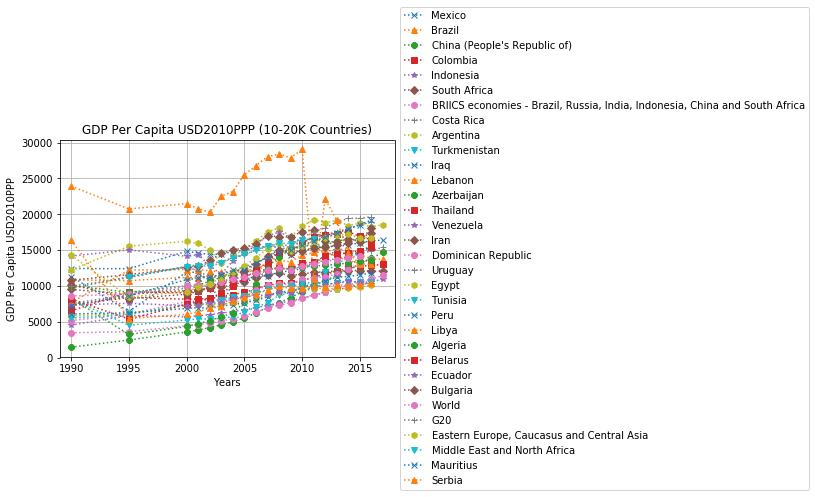

In [84]:
countries = tuple(GDP_10k_20k_df['Country'].unique())
markers = ['x', '^', '8', 's', '*', 'D', 'o', '+', 'h', 'v']
counter = 0

for country in countries:
    df = GDP_df.loc[GDP_df['Country'] == country, :].reset_index()
    years = tuple(df['Year'])
    GDP_values = tuple(df['GDP Per Capita USD2010PPP'])
    plt.plot(years, GDP_values, marker=markers[counter], linestyle=':')
    if counter < 9:
        counter += 1
    else:
        counter = 0

major_ticks = np.arange(1990, 2020, 5)
plt.xticks(major_ticks)
plt.title('GDP Per Capita USD2010PPP (10-20K Countries)')
plt.xlabel('Years')
plt.ylabel('GDP Per Capita USD2010PPP')
plt.xlim([1989,2018])
plt.legend(countries, loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

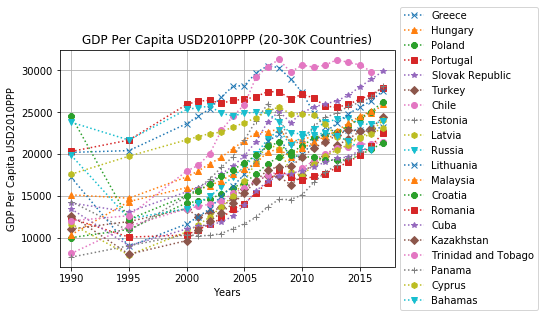

In [85]:
countries = tuple(GDP_20k_30k_df['Country'].unique())
markers = ['x', '^', '8', 's', '*', 'D', 'o', '+', 'h', 'v']
counter = 0

for country in countries:
    df = GDP_df.loc[GDP_df['Country'] == country, :].reset_index()
    years = tuple(df['Year'])
    GDP_values = tuple(df['GDP Per Capita USD2010PPP'])
    plt.plot(years, GDP_values, marker=markers[counter], linestyle=':')
    if counter < 9:
        counter += 1
    else:
        counter = 0

major_ticks = np.arange(1990, 2020, 5)
plt.xticks(major_ticks)
plt.title('GDP Per Capita USD2010PPP (20-30K Countries)')
plt.xlabel('Years')
plt.ylabel('GDP Per Capita USD2010PPP')
plt.xlim([1989,2018])
plt.legend(countries, loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

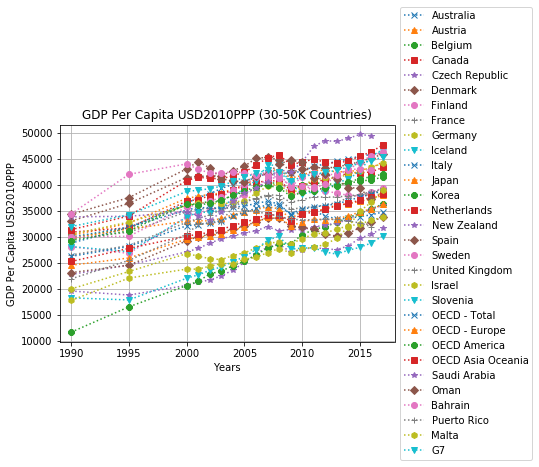

In [86]:
countries = tuple(GDP_30k_50k_df['Country'].unique())
markers = ['x', '^', '8', 's', '*', 'D', 'o', '+', 'h', 'v']
counter = 0

for country in countries:
    df = GDP_df.loc[GDP_df['Country'] == country, :].reset_index()
    years = tuple(df['Year'])
    GDP_values = tuple(df['GDP Per Capita USD2010PPP'])
    plt.plot(years, GDP_values, marker=markers[counter], linestyle=':')
    if counter < 9:
        counter += 1
    else:
        counter = 0

major_ticks = np.arange(1990, 2020, 5)
plt.xticks(major_ticks)
plt.title('GDP Per Capita USD2010PPP (30-50K Countries)')
plt.xlabel('Years')
plt.ylabel('GDP Per Capita USD2010PPP')
plt.xlim([1989,2018])
plt.legend(countries, loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

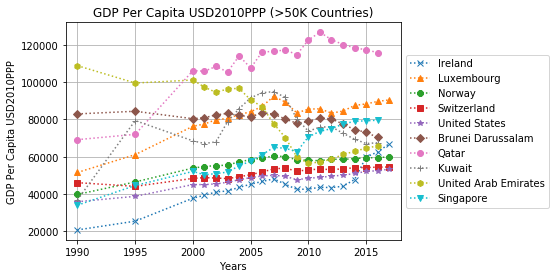

In [87]:
countries = tuple(GDP_50k_plus_df['Country'].unique())
markers = ['x', '^', '8', 's', '*', 'D', 'o', '+', 'h', 'v']
counter = 0

for country in countries:
    df = GDP_df.loc[GDP_df['Country'] == country, :].reset_index()
    years = tuple(df['Year'])
    GDP_values = tuple(df['GDP Per Capita USD2010PPP'])
    plt.plot(years, GDP_values, marker=markers[counter], linestyle=':')
    if counter < 9:
        counter += 1
    else:
        counter = 0

major_ticks = np.arange(1990, 2020, 5)
plt.xticks(major_ticks)
plt.title('GDP Per Capita USD2010PPP (>50K Countries)')
plt.xlabel('Years')
plt.ylabel('GDP Per Capita USD2010PPP')
plt.xlim([1989,2018])
plt.legend(countries, loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

In [89]:
country_list_1 = ['Australia', 'Austria', 'Belgium', 'Brazil', "China (People's Republic of)", 'Czech Republic', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Japan', 'Korea', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Slovak Republic', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'United Kingdom', 'United States']
country_list_2 = ['Australia', 'Austria', 'Belgium', 'Brazil', 'Canada', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'India', 'Ireland', 'Italy', 'Japan', 'Korea', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Slovak Republic', 'Slovenia', 'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'United Kingdom', 'United States']
country_list_3 = ['Australia', 'Austria', 'Belgium', 'Brazil', 'Canada', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'India', 'Ireland', 'Italy', 'Japan', 'Korea', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Slovak Republic', 'Slovenia', 'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'United Kingdom', 'United States']
country_list_4 = ['Australia', 'Austria', 'Belgium', 'Canada', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Japan', 'Korea', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Slovak Republic', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'United Kingdom', 'United States']
country_list_5 = ['Australia', 'Austria', 'Belgium', 'Brazil', 'Canada', "China (People's Republic of)", 'Czech Republic', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'India', 'Ireland', 'Italy', 'Japan', 'Korea', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Slovak Republic', 'Slovenia', 'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'United Kingdom', 'United States']
GDP_country_list = GDP_df['Country'].unique()

In [90]:
from collections import Counter

In [91]:
master_country_list = country_list_1 + country_list_2 + country_list_3 + country_list_4 + country_list_5
Counter(master_country_list)

Counter({'Australia': 5,
         'Austria': 5,
         'Belgium': 5,
         'Brazil': 4,
         "China (People's Republic of)": 2,
         'Czech Republic': 5,
         'Denmark': 5,
         'Finland': 5,
         'France': 5,
         'Germany': 5,
         'Greece': 5,
         'Hungary': 5,
         'Ireland': 5,
         'Italy': 5,
         'Japan': 5,
         'Korea': 5,
         'Netherlands': 5,
         'Norway': 5,
         'Poland': 5,
         'Portugal': 5,
         'Slovak Republic': 5,
         'Slovenia': 5,
         'Spain': 5,
         'Sweden': 5,
         'Switzerland': 5,
         'Turkey': 5,
         'United Kingdom': 5,
         'United States': 5,
         'Canada': 4,
         'India': 3,
         'South Africa': 3})

In [98]:
final_country_list = ['United Kingdom','Denmark','Germany','United States','Ireland','Slovak Republic',\
                      'Korea','Portugal','Norway','Switzerland','Sweden','Belgium','Finland','Italy',\
                      'Greece','Japan','Hungary','Spain','Austria','Netherlands','Czech Republic','France']

backup_countries = ['Canada', 'Brazil', 'Australia', 'Poland', 'Slovenia', 'Turkey']